Simple Naive Bayes classifier

In [49]:
from __future__ import division


%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# Setting background for plots
sns.set(style='darkgrid')


import numpy as np
import random
import re
import sklearn.datasets as skds
import sklearn.metrics as metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm

#%matplotlib inline
#from __future__ import division

#import matplotlib.pyplot as plt
#import numpy as np
#import pandas as pd
#import scipy.stats as stats
#import seaborn as sns

#from matplotlib import cm

# Setting background to plots
#sns.set(style="darkgrid")

----

In [9]:
corpi = {
    'original':'../data/corpus',
    'en':'../data/en_corpus',
    'de':'../data/de_corpus',
    'es':'../data/es_corpus',
    'fr':'../data/fr_corpus'
}
languages = ['en','de','es','fr']



lex_corpi = {
    'original' : '../data/lexical/corpus',
    'fr' : '../data/lexical/fr_corpus',
    'it' : '../data/lexical/it_corpus',
    'pt' : '../data/lexical/pt_corpus'
}
lex_languages = ['fr','it','pt']

**load_corpus**

Loads the entire experimental corpus and returns it as a bunch.
- _source_ source directory of the corpus
- _encoding_ encoding of the corpus.  Default is UTF-8.
- _languages_ languages to load from the corpus.  Default will load all.

In [10]:
def load_corpus(source="../data/corpus", encoding='UTF-8', languages=None):
    return skds.load_files(source, encoding=encoding, categories=languages, shuffle=True)

In [11]:
def test_load_corpus():
    corpus = load_corpus(languages=['en'])
    assert corpus.target_names[0] == 'en'
    
    corpus = load_corpus(languages=['de','es','fr'])
    print corpus.target_names
    assert len(corpus.target_names) == 3
    
    corpus = load_corpus()
    print corpus.target_names
    assert len(corpus.target_names) == 4
    
    
test_load_corpus()

['de', 'es', 'fr']
['de', 'en', 'es', 'fr']


**token_pattern**

Returns a token pattern for unicode alphabetical character words only.  No numbers or underscores allowed.8

In [36]:
def token_pattern():
    return '(?u)\\b[^\W_0-9]{2,}\\b'

In [37]:
def single_char_token_pattern():
    return '(?u)\\b[^\W_0-9]{1,}\\b'

**font_sizes**

In [100]:
title_fontsize = 20
x_axis_fontsize = 18
y_axis_fontsize = 18
legend_fontsize = 14

----
**Background:  Data **

A total of 4,000 paragraphs were extracted from the Wikipedia articles at _X_ - 1,000 messages for each of four languages: English, German, Spanish and French. Paragraphs were identified by `<p>` tag blocks.  Each paragraph had any embedded HTML tags used for formatting purposes removed. Embedded anchor tags were removed and replaced with the word or phrase appearing between the `<a></a>` tags as this was often a legimate word or phrase in the source language and the anchor was simply there to facilitate connectivity between articles on related concepts.

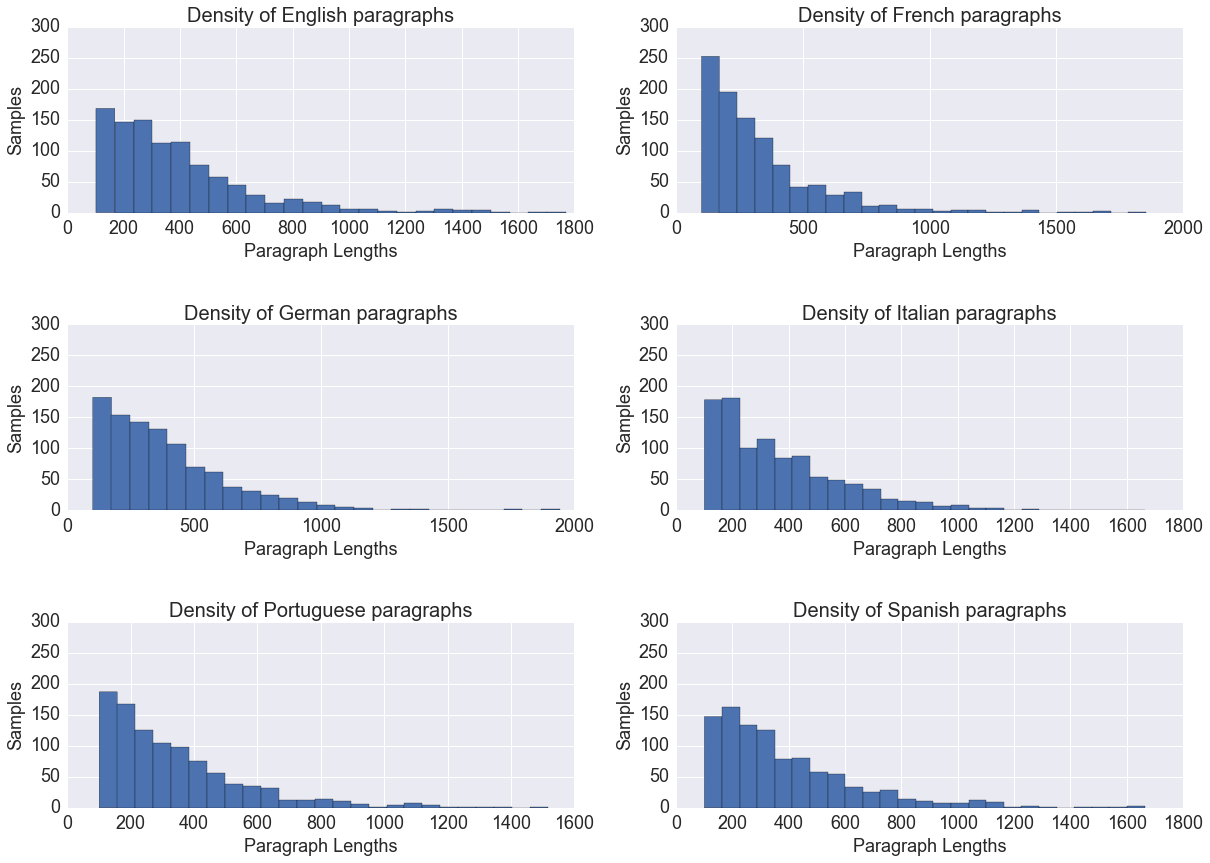

In [30]:
# Plot a histogram of the English message data
en_lengths = [len(p) for p in load_corpus(languages=['en']).data]
fr_lengths = [len(p) for p in load_corpus(languages=['fr']).data]
de_lengths = [len(p) for p in load_corpus(languages=['de']).data]
it_lengths = [len(p) for p in skds.load_files(lex_corpi['it'], encoding='UTF-8', shuffle=True, categories=['it']).data]              
pt_lengths = [len(p) for p in skds.load_files(lex_corpi['pt'], encoding='UTF-8', shuffle=True, categories=['pt']).data]  
es_lengths = [len(p) for p in load_corpus(languages=['es']).data]


title_fontsize = 20
x_axis_fontsize = 18
y_axis_fontsize = 18

bins = 25
y = [0, 300]
figure = plt.figure(figsize=(20,14))

def configure_axes(language, lengths, bins, y_lim, axes):
    axes.hist(lengths, bins)
    axes.set_title("Density of {0} paragraphs".format(language))
    axes.title.set_fontsize(title_fontsize)
    
    # Y axes
    axes.set_ylabel("Samples")
    axes.yaxis.get_label().set_fontsize(y_axis_fontsize)
    for tick in axes.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_axis_fontsize)
    axes.set_ylim(y_lim)
    
    # X axes
    axes.set_xlabel("Paragraph Lengths")
    axes.xaxis.get_label().set_fontsize(x_axis_fontsize)
    for tick in axes.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_axis_fontsize)
    return axes

# English      
en_axes = figure.add_subplot(3,2,1)
en_axes = configure_axes("English", en_lengths, bins, y, en_axes)
        
# French
fr_axes = figure.add_subplot(3,2,2)
fr_axes = configure_axes("French", fr_lengths, bins, y, fr_axes)

# German
de_axes = figure.add_subplot(3,2,3)
de_axes = configure_axes("German", de_lengths, bins, y, de_axes)

# Italian
it_axes = figure.add_subplot(3,2,4)
it_axes = configure_axes("Italian", it_lengths, bins, y, it_axes)

# Portuguese
pt_axes = figure.add_subplot(3,2,5)
pt_axes = configure_axes("Portuguese", pt_lengths, bins, y, pt_axes)

# Spanish
es_axes = figure.add_subplot(3,2,6)
es_axes = configure_axes("Spanish", es_lengths, bins, y, es_axes)

# Improved spacing between plots
figure.subplots_adjust(hspace=.6)

# Show the plots
plt.show()

English, German and Spanish paragraph lengths followed comparable distributions though smaller French paragraphs (<= 200 characters) are over-represented.  This is tolerable in the raw corpus as the individual experiments focus on sub-sampling messages over known distributions to produce test, training & validation sets that are balanced across and within the individual language classes.

**Unique term analysis**

Finding the lexical similarities between the languages.

In [59]:
import itertools

feature_list = []

en_corpus = skds.load_files(corpi['en'], encoding='UTF-8', shuffle=True, categories=['en'])
en_vectorizer = CountVectorizer(analyzer='word', lowercase=True, encoding='UTF-8', 
                                token_pattern=single_char_token_pattern())
en_features = set(en_vectorizer.fit(en_corpus.data).get_feature_names())
feature_list.append({'lang': 'English', 'features': en_features})

fr_corpus = skds.load_files(lex_corpi['fr'], encoding='UTF-8', shuffle=True, categories=['fr'])
fr_vectorizer = CountVectorizer(analyzer='word', lowercase=True, encoding='UTF-8', 
                                token_pattern=single_char_token_pattern())
fr_features = set(fr_vectorizer.fit(fr_corpus.data).get_feature_names())
feature_list.append({'lang': 'French', 'features': fr_features})

de_corpus = skds.load_files(corpi['de'], encoding='UTF-8', shuffle=True, categories=['de'])
de_vectorizer = CountVectorizer(analyzer='word', lowercase=True, encoding='UTF-8', 
                                token_pattern=single_char_token_pattern())
de_features = set(de_vectorizer.fit(de_corpus.data).get_feature_names())
feature_list.append({'lang': 'German', 'features': de_features})

es_corpus = skds.load_files(corpi['es'], encoding='UTF-8', shuffle=True, categories=['es'])
es_vectorizer = CountVectorizer(analyzer='word', lowercase=True, encoding='UTF-8', 
                                token_pattern=single_char_token_pattern())
es_features = set(es_vectorizer.fit(es_corpus.data).get_feature_names())
feature_list.append({'lang': 'Spanish', 'features': es_features})

it_corpus = skds.load_files(lex_corpi['it'], encoding='UTF-8', shuffle=True, categories=['it'])
it_vectorizer = CountVectorizer(analyzer='word', lowercase=True, encoding='UTF-8', 
                                token_pattern=single_char_token_pattern())
it_features = set(it_vectorizer.fit(it_corpus.data).get_feature_names())
feature_list.append({'lang': 'Italian', 'features': it_features})

pt_corpus = skds.load_files(lex_corpi['pt'], encoding='UTF-8', shuffle=True, categories=['pt'])
pt_vectorizer = CountVectorizer(analyzer='word', lowercase=True, encoding='UTF-8', 
                                token_pattern=single_char_token_pattern())
pt_features = set(pt_vectorizer.fit(pt_corpus.data).get_feature_names())
feature_list.append({'lang': 'Portuguese', 'features': pt_features})


pairs = [(l1, l2) for l1 in feature_list for l2 in feature_list if l1 != l2]
for pair in pairs:
    l1 = pair[0]
    l2 = pair[1]
    
    i = set.intersection(l1['features'], l2['features'])
    num = len(i)
    div = len(l1['features']) + len(l2['features']) - num
    sim = num /div
    print "{0}:{1} ,{2}:{3}, lexical sim: {4:.2f}%, intersecting terms: {5}".format(l1['lang'], 
                                                                                   len(l1['features']), 
                                                      l2['lang'], len(l2['features']), sim * 100, num)



English:9951 ,French:10947, lexical sim: 8.63%, intersecting terms: 1660
English:9951 ,German:13607, lexical sim: 5.27%, intersecting terms: 1179
English:9951 ,Spanish:12283, lexical sim: 5.73%, intersecting terms: 1205
English:9951 ,Italian:12363, lexical sim: 5.26%, intersecting terms: 1116
English:9951 ,Portuguese:11556, lexical sim: 5.54%, intersecting terms: 1129
French:10947 ,English:9951, lexical sim: 8.63%, intersecting terms: 1660
French:10947 ,German:13607, lexical sim: 3.61%, intersecting terms: 856
French:10947 ,Spanish:12283, lexical sim: 3.63%, intersecting terms: 814
French:10947 ,Italian:12363, lexical sim: 3.92%, intersecting terms: 880
French:10947 ,Portuguese:11556, lexical sim: 3.86%, intersecting terms: 836
German:13607 ,English:9951, lexical sim: 5.27%, intersecting terms: 1179
German:13607 ,French:10947, lexical sim: 3.61%, intersecting terms: 856
German:13607 ,Spanish:12283, lexical sim: 5.19%, intersecting terms: 1278
German:13607 ,Italian:12363, lexical sim: 3

**Experiment 1:**  Simple top-N feature selection*

We'll begin with a baseline experiment to determine classifier performance when selecting features (words & word n-grams) across a random sub-sample of the language to classify and its counter-examples.  This is just to give us a baseline.  We'll use the simplest vectorizer in sklearn and 2 types of classifiers:  Naive Bayes & SVM.
- Sample size of 10% across the whole corpus for constructing word features
- Word features are identified as follows:
    - alpha only (no numeric characters)
    - 1 character minimum length
- Top N word features are selected where N in [1,30]. Top words are selected based on their frequency across the corpus.  That is, how many documents they show up within.  
- Classifiers used were Naive Bayes & SVM with a Linear Kernel
    - Naive Bayes w/ default configuration (alpha = 1,  Laplace smoothing), fit_prior = True
    - SVM w/ RBF & C=1, default RBF gamma?
- 10-fold CrossValidation run, reporting the mean _test_ metrics for Accuracy, F1 score & AUC.
    
First series of tests were run using the original corpus of 4 languages:  en, fr, de, es

----------------------------------
----------------------------------
Starting experiments for language fr
----------------------------------
Results for (lang: fr, features: 1)
Features selected: [u'de']
Naive Bayes:
	Accuracy 0.75, +\/-95%CI 0.0
	F1 0.857142857143, +\/-95%CI 0.0
	auc 0.5, +\-95%CI 0.0
SVM:
	Accuracy 0.75675, +\/-95%CI 0.0331700165812
	F1 0.834878972892, +\/-95%CI 0.0230746864762
	auc 0.728308333333, +\-95%CI 0.114695908335
----------------------------------
Results for (lang: fr, features: 2)
Features selected: [u'de', u'the']
Naive Bayes:
	Accuracy 0.7255, +\/-95%CI 0.0500899191455
	F1 0.802187882073, +\/-95%CI 0.0395467328409
	auc 0.772203333333, +\-95%CI 0.0503094530547
SVM:
	Accuracy 0.772, +\/-95%CI 0.0436348484585
	F1 0.844673142044, +\/-95%CI 0.0272941462776
	auc 0.74912, +\-95%CI 0.0625184911313
----------------------------------
Results for (lang: fr, features: 3)
Features selected: [u'de', u'la', u'the']
Naive Bayes:
	Accuracy 0.7195, +\/-95%CI 0.0442040722

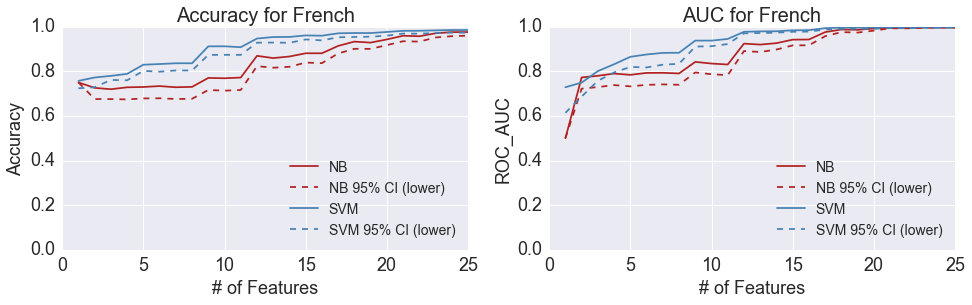

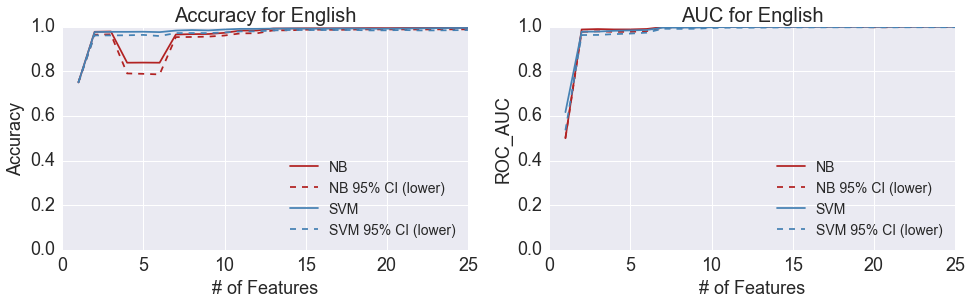

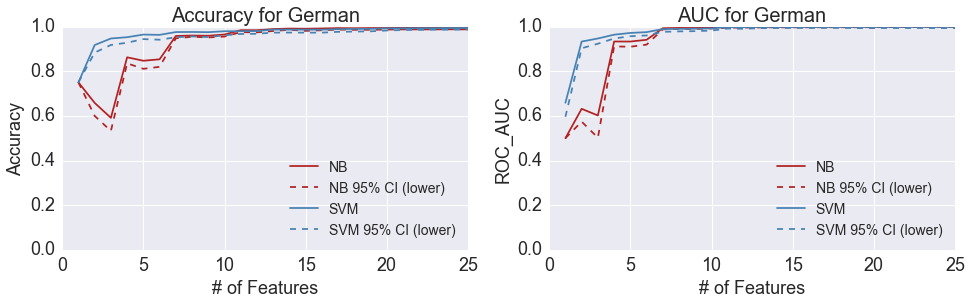

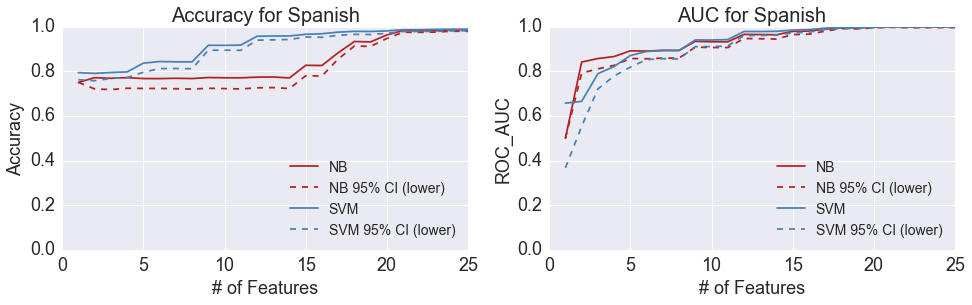

In [119]:
random.seed(123454321)
np.random.seed(123454321)

def experiment_1(corpi, language, num_features, feature_sample):
    
    # Fit to the feature space
    vectorizer = CountVectorizer(analyzer='word', lowercase=True, encoding='UTF-8',
                                   max_features=num_features, token_pattern=single_char_token_pattern())
    vectorizer.fit(feature_sample)
    
    # Load the language corpus & fit a Naive Bayes classifier
    corpus = skds.load_files(corpi[language], encoding='UTF-8', shuffle=True)
    X = vectorizer.transform(corpus.data)
    y = corpus.target
    
    # Fit and evaluate a Naive Bayes Classifier
    classifier = MultinomialNB(fit_prior=True)
    scoring = ['accuracy','f1','roc_auc']
    nb_results = cross_validate(classifier, X, y, cv=10, scoring=scoring)
    
    # Fit and evaluate an SVM
    classifier = svm.SVC(kernel='rbf', C=1)
    svm_results = cross_validate(classifier, X, y, cv=10, scoring=scoring)
    
    # kernel=rbf (default)
    # decision function shape = ovo ( one-vs-rest) - original decision function in libsvm
    #  tol is the default 1e-3
    # default C = 1
    return {
        'num_features' : num_features,
        'features': vectorizer.get_feature_names(),
        'NB' : {
            'accuracy' : nb_results['test_accuracy'].mean(),
            'accuracy_95CI': nb_results['test_accuracy'].std() * 2,
            'f1' : nb_results['test_f1'].mean(),
            'f1_95CI': nb_results['test_f1'].std() * 2,
            'auc' : nb_results['test_roc_auc'].mean(),
            'auc_95CI': nb_results['test_roc_auc'].std() * 2
        },
        'SVM' : {
            'accuracy': svm_results['test_accuracy'].mean(),
            'accuracy_95CI' : svm_results['test_accuracy'].std() * 2,
            'f1': svm_results['test_f1'].mean(),
            'f1_95CI': svm_results['test_f1'].std() * 2,
            'auc': svm_results['test_roc_auc'].mean(),
            'auc_95CI': svm_results['test_roc_auc'].std() * 2
        }
    }


lang_map = {
    'en':'English',
    'fr':'French',
    'de':'German',
    'es':'Spanish'
}

# Get the feature sampling corpus once (10% of the whole corpora)
fs_corpus = skds.load_files(corpi['original'], encoding='UTF-8', shuffle=True)
feature_sample = train_test_split(fs_corpus.data, fs_corpus.target, train_size=.10)[0]

# Run experiment for each language
for language in lang_map:
    
    # Run tests for a language
    print "----------------------------------"
    print "----------------------------------"
    print "Starting experiments for language {0}".format(language)
    
    feature_ranks = []
    results = []
    
    # run the experiment
    for num_features in range(1, 25+1):
        exp_res = experiment_1(corpi, language, num_features, feature_sample)
        print "----------------------------------"
        print "Results for (lang: {0}, features: {1})".format(language, exp_res['num_features'])
        print "Features selected: {0}".format(exp_res['features'])
        print "Naive Bayes:"
        print "\tAccuracy {0}, +\/-95%CI {1}".format(exp_res['NB']['accuracy'], exp_res['NB']['accuracy_95CI'])
        print "\tF1 {0}, +\/-95%CI {1}".format(exp_res['NB']['f1'], exp_res['NB']['f1_95CI'])
        print "\tauc {0}, +\-95%CI {1}".format(exp_res['NB']['auc'],exp_res['NB']['auc_95CI'] )
        print "SVM:"
        print "\tAccuracy {0}, +\/-95%CI {1}".format(exp_res['SVM']['accuracy'], exp_res['SVM']['accuracy_95CI'])
        print "\tF1 {0}, +\/-95%CI {1}".format(exp_res['SVM']['f1'], exp_res['SVM']['f1_95CI'])
        print "\tauc {0}, +\-95%CI {1}".format(exp_res['SVM']['auc'],exp_res['SVM']['auc_95CI'] )
        results.append(exp_res)
        
        if len(feature_ranks) == 0:
            feature_ranks.append(exp_res['features'][0])
        else:
            for feature in exp_res['features']:
                if feature not in feature_ranks:
                    feature_ranks.append(feature)

    # Plotting NB
    figure = plt.figure(figsize=(16,4))
    nf = [result['num_features'] for result in results]
    
    # Accuracy on NB, SVM
    axes = figure.add_subplot(1,2,1)
    axes.set_title("Accuracy for {0}".format(lang_map[language]))
    axes.title.set_fontsize(title_fontsize)
    # NB plot
    nb_acc = [result['NB']['accuracy'] for result in results]
    nb_acc_lower = [result['NB']['accuracy'] - result['NB']['accuracy_95CI'] for result in results]
    h1, = axes.plot(nf, nb_acc, color='firebrick', label='NB')
    h2, = axes.plot(nf, nb_acc_lower, color='firebrick', linestyle='dashed', label='NB 95% CI (lower)')
    # SVM plot
    svm_acc = [result['SVM']['accuracy'] for result in results]
    svm_acc_lower = [result['SVM']['accuracy'] - result['SVM']['accuracy_95CI'] for result in results]
    h3, = axes.plot(nf, svm_acc, color='steelblue', label='SVM')
    h4, = axes.plot(nf, svm_acc_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h1, h2,h3, h4], loc='lower right', prop= {'size': legend_fontsize})
    axes.set_ylim([0,1])
    axes.set_ylabel("Accuracy")
    axes.set_ylim([0,1])
    axes.yaxis.get_label().set_fontsize(y_axis_fontsize)
    for tick in axes.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_axis_fontsize)
    axes.set_xlabel("# of Features")
    axes.xaxis.get_label().set_fontsize(x_axis_fontsize)
    for tick in axes.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_axis_fontsize)


    # AUC on NB, SVM
    axes = figure.add_subplot(1,2,2)
    axes.set_title("AUC for {0}".format(lang_map[language]))
    axes.title.set_fontsize(title_fontsize)
    # NB plot
    nb_auc = [result['NB']['auc'] for result in results]
    nb_auc_lower = [result['NB']['auc'] - result['NB']['auc_95CI'] for result in results]
    h1, = axes.plot(nf, nb_auc, color='firebrick', label='NB')
    h2, = axes.plot(nf, nb_auc_lower, color='firebrick', linestyle='dashed', label='NB 95% CI (lower)')
    # SVM plot
    svm_auc = [result['SVM']['auc'] for result in results]
    svm_auc_lower = [result['SVM']['auc'] - result['SVM']['auc_95CI'] for result in results]
    h3, = axes.plot(nf, svm_auc, color='steelblue', label='SVM')
    h4, = axes.plot(nf, svm_auc_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h1, h2, h3, h4], loc='lower right', prop= {'size': legend_fontsize})
    axes.set_ylim([0,1])
    axes.set_ylabel("ROC_AUC")
    axes.yaxis.get_label().set_fontsize(y_axis_fontsize)
    for tick in axes.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_axis_fontsize)
    axes.set_xlabel("# of Features")
    axes.xaxis.get_label().set_fontsize(x_axis_fontsize)
    for tick in axes.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_axis_fontsize)
    axes.set_ylim([0,1])

    print "Features in rank order were {0}".format(feature_ranks)
    print "Finished experiments for language {0}".format(language)

------
**Experiment 2: Feature selection by language**
Considering the results using features extracted from the general codebase, we've just built a feature space with the hope that the individual categories (languages) differentiate within those top-N categories.  As we saw, it took **X**  features before any real discrimintaory power showed up. 

Now we'll investigate the selection of features by language, rather than training each language classifier on the same feature set. 

Parameters for this test are:
- Sample size of 10% across the _language_ corpus for constructing word features
- Word features identified as follows:
    - alpha only (no numeric characters)
    - 1 character minimum length
- Top N word features are selected where N in [1,25].  Top words are selected based on their count within the language corpus sample
- Classifiers used were NaiveBayes & SVM:
    - Naive Bayes w/ default configuration:  alpha=1 (Laplace smoothing),  fit_prior=True
    - SVM w/ RBF & C=1, default RBF gamma?
- 10-fold Cross Validation run, reporting the mean test metrics for Accuracy, F1 Score & AUC

----------------------------------
----------------------------------
Starting experiments for language fr
----------------------------------
Results for (lang: fr, features: 1)
Features selected: [u'de']
Naive Bayes:
	Accuracy 0.75, +\/-95%CI 0.0
	F1 0.857142857143, +\/-95%CI 0.0
	auc 0.5, +\-95%CI 0.0
SVM:
	Accuracy 0.75675, +\/-95%CI 0.0331700165812
	F1 0.834878972892, +\/-95%CI 0.0230746864762
	auc 0.728308333333, +\-95%CI 0.114695908335
----------------------------------
Results for (lang: fr, features: 2)
Features selected: [u'de', u'la']
Naive Bayes:
	Accuracy 0.75, +\/-95%CI 0.0
	F1 0.857142857143, +\/-95%CI 0.0
	auc 0.507151666667, +\-95%CI 0.0808249816304
SVM:
	Accuracy 0.771, +\/-95%CI 0.0206397674406
	F1 0.848876992757, +\/-95%CI 0.015419638245
	auc 0.737675, +\-95%CI 0.107145019327
----------------------------------
Results for (lang: fr, features: 3)
Features selected: [u'de', u'la', u'le']
Naive Bayes:
	Accuracy 0.88925, +\/-95%CI 0.0408074748055
	F1 0.930214251959, +\/-

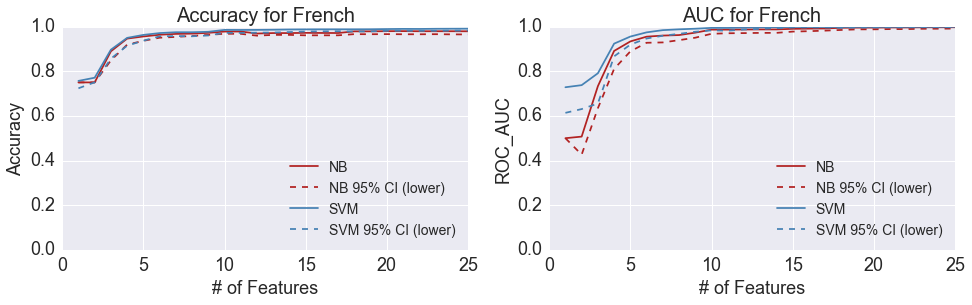

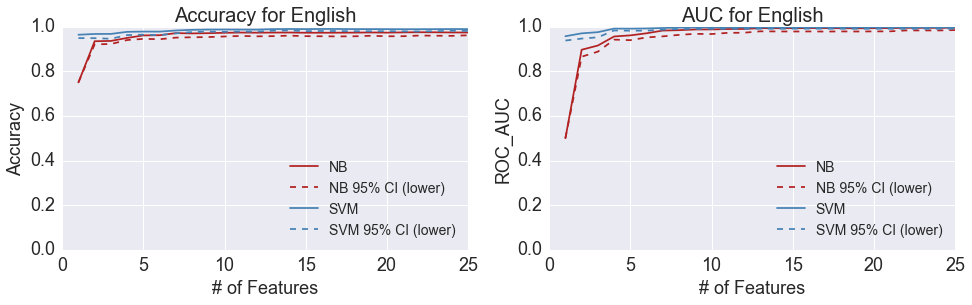

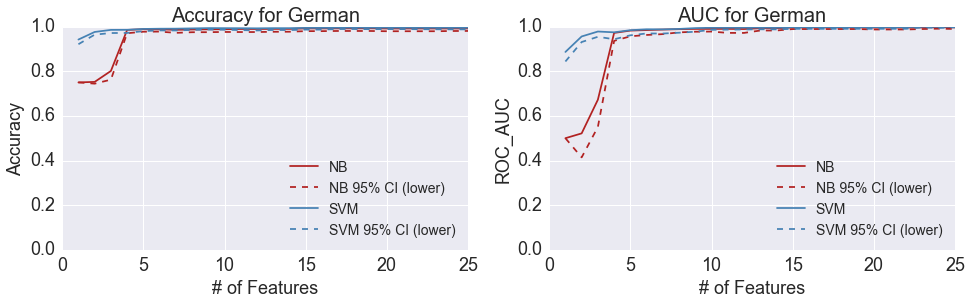

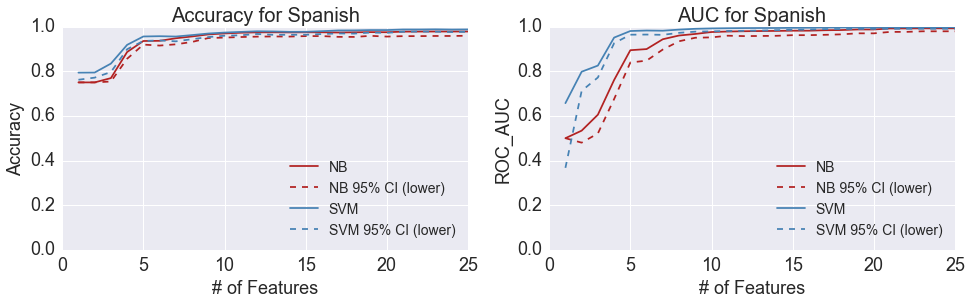

In [122]:
def experiment_2(corpi, language, num_features, feature_samples):
    # Fit the vectorizer based on the number of features
    vectorizer = CountVectorizer(analyzer='word', lowercase=True, encoding='UTF-8',
                                   max_features=num_features, token_pattern=single_char_token_pattern())
    vectorizer.fit(feature_samples)
    
    # Load the language corpus & fit a Naive Bayes classifier
    corpus = skds.load_files(corpi[language], encoding='UTF-8', shuffle=True)
    X = vectorizer.transform(corpus.data)
    y = corpus.target
    
    # Fit and evaluate a Naive Bayes Classifier
    classifier = MultinomialNB(fit_prior=True)
    scoring = ['accuracy','f1','roc_auc']
    nb_results = cross_validate(classifier, X, y, cv=10, scoring=scoring)
    
    # Fit and evaluate an SVM
    classifier = svm.SVC(kernel='rbf', C=1)
    svm_results = cross_validate(classifier, X, y, cv=10, scoring=scoring)
    
    # kernel=rbf (default)
    # decision function shape = ovo ( one-vs-rest) - original decision function in libsvm
    #  tol is the default 1e-3
    # default C = 1
    return {
        'num_features' : num_features,
        'features': vectorizer.get_feature_names(),
        'NB' : {
            'accuracy' : nb_results['test_accuracy'].mean(),
            'accuracy_95CI': nb_results['test_accuracy'].std() * 2,
            'f1' : nb_results['test_f1'].mean(),
            'f1_95CI': nb_results['test_f1'].std() * 2,
            'auc' : nb_results['test_roc_auc'].mean(),
            'auc_95CI': nb_results['test_roc_auc'].std() * 2
        },
        'SVM' : {
            'accuracy': svm_results['test_accuracy'].mean(),
            'accuracy_95CI' : svm_results['test_accuracy'].std() * 2,
            'f1': svm_results['test_f1'].mean(),
            'f1_95CI': svm_results['test_f1'].std() * 2,
            'auc': svm_results['test_roc_auc'].mean(),
            'auc_95CI': svm_results['test_roc_auc'].std() * 2
        }
    }


# Run experiment for each language
for language in lang_map:
    
    # Run tests for a language
    print "----------------------------------"
    print "----------------------------------"
    print "Starting experiments for language {0}".format(language)
    
    # Extract feature space
    corpus = skds.load_files(corpi[language], encoding='UTF-8', shuffle=True, categories=[language])
    feature_sample = train_test_split(corpus.data, corpus.target, train_size=.10)[0]
    
    feature_ranks = []
    results = []
    
    # run the experiment
    for num_features in range(1, 25+1):
        exp_res = experiment_2(corpi, language, num_features, feature_sample)
        print "----------------------------------"
        print "Results for (lang: {0}, features: {1})".format(language, exp_res['num_features'])
        print "Features selected: {0}".format(exp_res['features'])
        print "Naive Bayes:"
        print "\tAccuracy {0}, +\/-95%CI {1}".format(exp_res['NB']['accuracy'], exp_res['NB']['accuracy_95CI'])
        print "\tF1 {0}, +\/-95%CI {1}".format(exp_res['NB']['f1'], exp_res['NB']['f1_95CI'])
        print "\tauc {0}, +\-95%CI {1}".format(exp_res['NB']['auc'],exp_res['NB']['auc_95CI'] )
        print "SVM:"
        print "\tAccuracy {0}, +\/-95%CI {1}".format(exp_res['SVM']['accuracy'], exp_res['SVM']['accuracy_95CI'])
        print "\tF1 {0}, +\/-95%CI {1}".format(exp_res['SVM']['f1'], exp_res['SVM']['f1_95CI'])
        print "\tauc {0}, +\-95%CI {1}".format(exp_res['SVM']['auc'],exp_res['SVM']['auc_95CI'] )
        results.append(exp_res)
        
        if len(feature_ranks) == 0:
            feature_ranks.append(exp_res['features'][0])
        else:
            for feature in exp_res['features']:
                if feature not in feature_ranks:
                    feature_ranks.append(feature)

    # Plotting NB
    figure = plt.figure(figsize=(16,4))
    nf = [result['num_features'] for result in results]
    
    # Accuracy on NB, SVM
    axes = figure.add_subplot(1,2,1)
    axes.set_title("Accuracy for {0}".format(lang_map[language]))
    axes.title.set_fontsize(title_fontsize)
    # NB plot
    nb_acc = [result['NB']['accuracy'] for result in results]
    nb_acc_lower = [result['NB']['accuracy'] - result['NB']['accuracy_95CI'] for result in results]
    h1, = axes.plot(nf, nb_acc, color='firebrick', label='NB')
    h2, = axes.plot(nf, nb_acc_lower, color='firebrick', linestyle='dashed', label='NB 95% CI (lower)')
    # SVM plot
    svm_acc = [result['SVM']['accuracy'] for result in results]
    svm_acc_lower = [result['SVM']['accuracy'] - result['SVM']['accuracy_95CI'] for result in results]
    h3, = axes.plot(nf, svm_acc, color='steelblue', label='SVM')
    h4, = axes.plot(nf, svm_acc_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h1, h2,h3, h4], loc='lower right', prop= {'size': legend_fontsize})
    axes.set_ylim([0,1])
    axes.set_ylabel("Accuracy")
    axes.set_ylim([0,1])
    axes.yaxis.get_label().set_fontsize(y_axis_fontsize)
    for tick in axes.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_axis_fontsize)
    axes.set_xlabel("# of Features")
    axes.xaxis.get_label().set_fontsize(x_axis_fontsize)
    for tick in axes.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_axis_fontsize)


    # AUC on NB, SVM
    axes = figure.add_subplot(1,2,2)
    axes.set_title("AUC for {0}".format(lang_map[language]))
    axes.title.set_fontsize(title_fontsize)
    # NB plot
    nb_auc = [result['NB']['auc'] for result in results]
    nb_auc_lower = [result['NB']['auc'] - result['NB']['auc_95CI'] for result in results]
    h1, = axes.plot(nf, nb_auc, color='firebrick', label='NB')
    h2, = axes.plot(nf, nb_auc_lower, color='firebrick', linestyle='dashed', label='NB 95% CI (lower)')
    # SVM plot
    svm_auc = [result['SVM']['auc'] for result in results]
    svm_auc_lower = [result['SVM']['auc'] - result['SVM']['auc_95CI'] for result in results]
    h3, = axes.plot(nf, svm_auc, color='steelblue', label='SVM')
    h4, = axes.plot(nf, svm_auc_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h1, h2, h3, h4], loc='lower right', prop= {'size': legend_fontsize})
    axes.set_ylim([0,1])
    axes.set_ylabel("ROC_AUC")
    axes.yaxis.get_label().set_fontsize(y_axis_fontsize)
    for tick in axes.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_axis_fontsize)
    axes.set_xlabel("# of Features")
    axes.xaxis.get_label().set_fontsize(x_axis_fontsize)
    for tick in axes.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_axis_fontsize)
    axes.set_ylim([0,1])

    print "Features in rank order were {0}".format(feature_ranks)
    print "Finished experiments for language {0}".format(language)

**Experiment 3: Feature selection by language, Binary features (word is present or not)**

Focusing on language specific sampling for classification features appears to have improved things (why?), perhaps by selecting features relevant to that language's lexicon.

Within the corpus itself, we can consider looking at the feature frequency. For each document, how often does an individual term appear within the document?  

Parameters for this test are:
- Sample size of 10% from the language corpus for identifying word features
- Word features identified as follows:
    - alpha only (no numeric characters)
    - 1 character minimum length
- Top N word features are selected where N in [1,25].  Top words are selected based on the frequency of their appearance in the corpus (# of unique documents they are in). The word feature presence in a document is modeled as a binary indicator variable. 
- Classifiers used were Naive Bayes & SVM
    - Naive Bayes w/ default configuration:  alpha=1 (Laplace smoothing),  fit_prior=True
    - SVM w/ RBF & C=1, default RBF gamma
- 10-fold Cross Validation run, reporting the mean test statistics for Accuracy, F1 & AUC

----

Experiment 3
----------------------------------
----------------------------------
Starting experiments for language fr
----------------------------------
Results for (lang: fr, features: 1)
Features selected: [u'de']
Naive Bayes:
	Accuracy 0.75, +\/-95%CI 0.0
	F1 0.857142857143, +\/-95%CI 0.0
	auc 0.5, +\-95%CI 0.0
SVM:
	Accuracy 0.75, +\/-95%CI 0.0
	F1 0.857142857143, +\/-95%CI 0.0
	auc 0.771166666667, +\-95%CI 0.0490815647672
----------------------------------
Results for (lang: fr, features: 2)
Features selected: [u'de', u'la']
Naive Bayes:
	Accuracy 0.75, +\/-95%CI 0.0
	F1 0.857142857143, +\/-95%CI 0.0
	auc 0.421676666667, +\-95%CI 0.3210990291
SVM:
	Accuracy 0.74775, +\/-95%CI 0.00906917857361
	F1 0.855356916827, +\/-95%CI 0.00726829510973
	auc 0.460363333333, +\-95%CI 0.423789896267
----------------------------------
Results for (lang: fr, features: 3)
Features selected: [u'de', u'la', u'le']
Naive Bayes:
	Accuracy 0.89325, +\/-95%CI 0.0358503835405
	F1 0.931571849807, +\/-95%CI

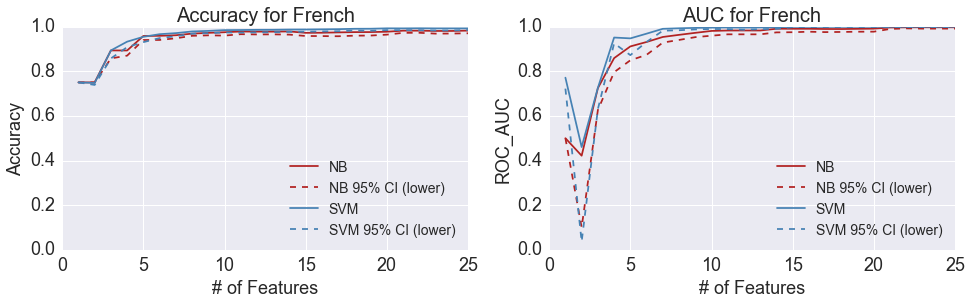

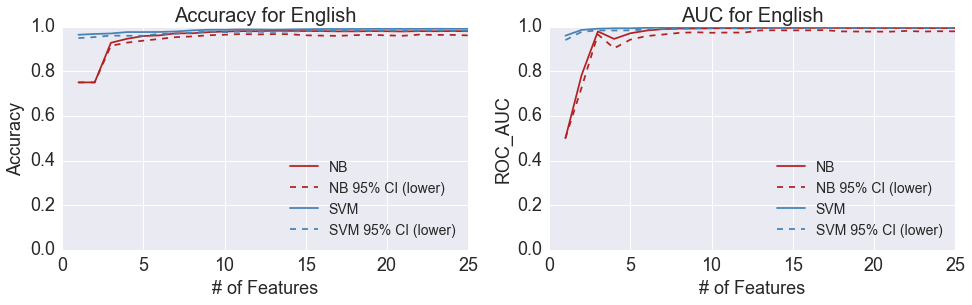

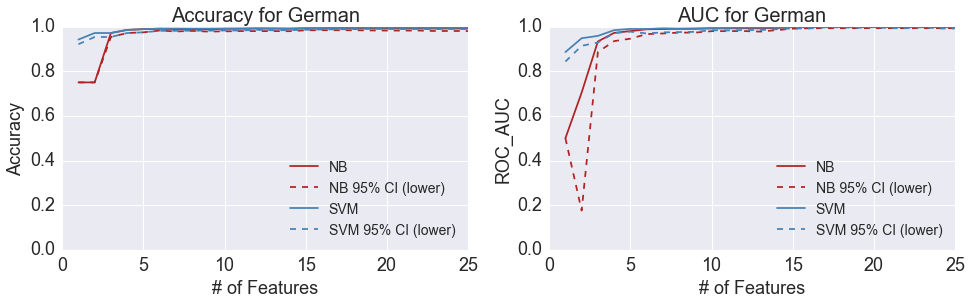

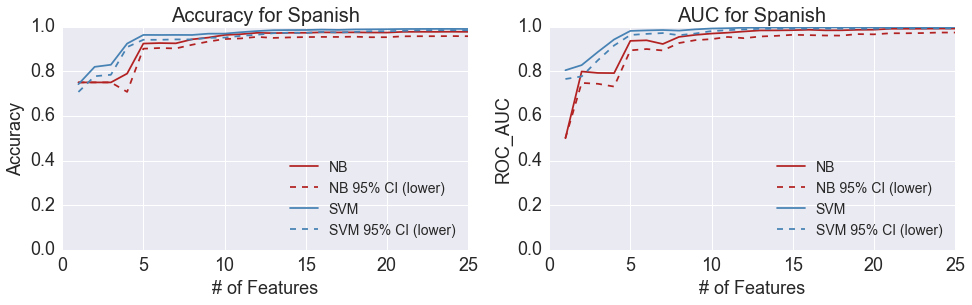

In [123]:
def experiment_3(corpi, language, num_features, feature_sample):
    
    # Discover features by count
    vectorizer = CountVectorizer(analyzer='word', lowercase=True, encoding='UTF-8', 
                                   max_features=num_features, token_pattern=single_char_token_pattern(), binary=True)
    vectorizer.fit(feature_sample)
    
    # Load the language corpus & fit a Naive Bayes classifier
    corpus = skds.load_files(corpi[language], encoding='UTF-8', shuffle=True)
    X = vectorizer.transform(corpus.data)
    y = corpus.target
    
    # Fit and evaluate a Naive Bayes Classifier
    classifier = MultinomialNB(fit_prior=True)
    scoring = ['accuracy','f1','roc_auc']
    nb_results = cross_validate(classifier, X, y, cv=10, scoring=scoring)
    
    # Fit and evaluate an SVM
    classifier = svm.SVC(kernel='rbf', C=1)
    svm_results = cross_validate(classifier, X, y, cv=10, scoring=scoring)
    
    # kernel=rbf (default)
    # decision function shape = ovo ( one-vs-rest) - original decision function in libsvm
    #  tol is the default 1e-3
    # default C = 1
    return {
        'num_features' : num_features,
        'features': vectorizer.get_feature_names(),
        'NB' : {
            'accuracy' : nb_results['test_accuracy'].mean(),
            'accuracy_95CI': nb_results['test_accuracy'].std() * 2,
            'f1' : nb_results['test_f1'].mean(),
            'f1_95CI': nb_results['test_f1'].std() * 2,
            'auc' : nb_results['test_roc_auc'].mean(),
            'auc_95CI': nb_results['test_roc_auc'].std() * 2
        },
        'SVM' : {
            'accuracy': svm_results['test_accuracy'].mean(),
            'accuracy_95CI' : svm_results['test_accuracy'].std() * 2,
            'f1': svm_results['test_f1'].mean(),
            'f1_95CI': svm_results['test_f1'].std() * 2,
            'auc': svm_results['test_roc_auc'].mean(),
            'auc_95CI': svm_results['test_roc_auc'].std() * 2
        }
    }


# Run experiment for each language
print "Experiment 3"
for language in lang_map:
    
    # Run tests for a language
    print "----------------------------------"
    print "----------------------------------"
    print "Starting experiments for language {0}".format(language)
    
    # Extract feature space
    corpus = skds.load_files(corpi[language], encoding='UTF-8', shuffle=True, categories=[language])
    feature_sample = train_test_split(corpus.data, corpus.target, train_size=.10)[0]
    
    feature_ranks = []
    results = []
    
    # run the experiment
    for num_features in range(1, 25+1):
        exp_res = experiment_3(corpi, language, num_features, feature_sample)
        print "----------------------------------"
        print "Results for (lang: {0}, features: {1})".format(language, exp_res['num_features'])
        print "Features selected: {0}".format(exp_res['features'])
        print "Naive Bayes:"
        print "\tAccuracy {0}, +\/-95%CI {1}".format(exp_res['NB']['accuracy'], exp_res['NB']['accuracy_95CI'])
        print "\tF1 {0}, +\/-95%CI {1}".format(exp_res['NB']['f1'], exp_res['NB']['f1_95CI'])
        print "\tauc {0}, +\-95%CI {1}".format(exp_res['NB']['auc'],exp_res['NB']['auc_95CI'] )
        print "SVM:"
        print "\tAccuracy {0}, +\/-95%CI {1}".format(exp_res['SVM']['accuracy'], exp_res['SVM']['accuracy_95CI'])
        print "\tF1 {0}, +\/-95%CI {1}".format(exp_res['SVM']['f1'], exp_res['SVM']['f1_95CI'])
        print "\tauc {0}, +\-95%CI {1}".format(exp_res['SVM']['auc'],exp_res['SVM']['auc_95CI'] )
        results.append(exp_res)
        
        if len(feature_ranks) == 0:
            feature_ranks.append(exp_res['features'][0])
        else:
            for feature in exp_res['features']:
                if feature not in feature_ranks:
                    feature_ranks.append(feature)

    # Plotting NB
    figure = plt.figure(figsize=(16,4))
    nf = [result['num_features'] for result in results]
    
    # Accuracy on NB, SVM
    axes = figure.add_subplot(1,2,1)
    axes.set_title("Accuracy for {0}".format(lang_map[language]))
    axes.title.set_fontsize(title_fontsize)
    # NB plot
    nb_acc = [result['NB']['accuracy'] for result in results]
    nb_acc_lower = [result['NB']['accuracy'] - result['NB']['accuracy_95CI'] for result in results]
    h1, = axes.plot(nf, nb_acc, color='firebrick', label='NB')
    h2, = axes.plot(nf, nb_acc_lower, color='firebrick', linestyle='dashed', label='NB 95% CI (lower)')
    # SVM plot
    svm_acc = [result['SVM']['accuracy'] for result in results]
    svm_acc_lower = [result['SVM']['accuracy'] - result['SVM']['accuracy_95CI'] for result in results]
    h3, = axes.plot(nf, svm_acc, color='steelblue', label='SVM')
    h4, = axes.plot(nf, svm_acc_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h1, h2,h3, h4], loc='lower right', prop= {'size': legend_fontsize})
    axes.set_ylim([0,1])
    axes.set_ylabel("Accuracy")
    axes.set_ylim([0,1])
    axes.yaxis.get_label().set_fontsize(y_axis_fontsize)
    for tick in axes.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_axis_fontsize)
    axes.set_xlabel("# of Features")
    axes.xaxis.get_label().set_fontsize(x_axis_fontsize)
    for tick in axes.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_axis_fontsize)


    # AUC on NB, SVM
    axes = figure.add_subplot(1,2,2)
    axes.set_title("AUC for {0}".format(lang_map[language]))
    axes.title.set_fontsize(title_fontsize)
    # NB plot
    nb_auc = [result['NB']['auc'] for result in results]
    nb_auc_lower = [result['NB']['auc'] - result['NB']['auc_95CI'] for result in results]
    h1, = axes.plot(nf, nb_auc, color='firebrick', label='NB')
    h2, = axes.plot(nf, nb_auc_lower, color='firebrick', linestyle='dashed', label='NB 95% CI (lower)')
    # SVM plot
    svm_auc = [result['SVM']['auc'] for result in results]
    svm_auc_lower = [result['SVM']['auc'] - result['SVM']['auc_95CI'] for result in results]
    h3, = axes.plot(nf, svm_auc, color='steelblue', label='SVM')
    h4, = axes.plot(nf, svm_auc_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h1, h2, h3, h4], loc='lower right', prop= {'size': legend_fontsize})
    axes.set_ylim([0,1])
    axes.set_ylabel("ROC_AUC")
    axes.yaxis.get_label().set_fontsize(y_axis_fontsize)
    for tick in axes.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_axis_fontsize)
    axes.set_xlabel("# of Features")
    axes.xaxis.get_label().set_fontsize(x_axis_fontsize)
    for tick in axes.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_axis_fontsize)
    axes.set_ylim([0,1])

    print "Features in rank order were {0}".format(feature_ranks)
    print "Finished experiments for language {0}".format(language)




---

**Experiment 4: Feature selection by language, Top-N represented as term frequency in document**

Focusing on language specific sampling for classification features appears to have improved things (why?), perhaps by selecting features relevant to that language's lexicon.

Within the corpus itself, we can consider looking at the feature frequency. For each document, how often does an individual term appear within the document?  

Parameters for this test are:
- Sample size of 10% from the language corpus for identifying word features
- Word features identified as follows:
    - alpha only (no numeric characters)
    - 1 character minimum length
- Top N word features are selected where N in [1,30].  Top words are selected based on their frequency within the language corpus sample.  Use_idf=False
- Classifiers used were Naive Bayes & SVM
    - Naive Bayes w/ default configuration:  alpha=1 (Laplace smoothing),  fit_prior=True
    - SVM w/ RBF & C=1, default RBF gamma
- 10-fold Cross Validation run, reporting the mean test statistics for Accuracy, F1 & AUC

Results for experiment 4
----------------------------------
----------------------------------
Starting experiments for language en
----------------------------------
Results for (lang: en, features: 1)
Features selected: [u'the']
Naive Bayes:
	Accuracy 0.75, +\/-95%CI 0.0
	F1 0.857142857143, +\/-95%CI 0.0
	auc 0.5, +\-95%CI 0.0
SVM:
	Accuracy 0.9635, +\/-95%CI 0.0150332963784
	F1 0.975463990759, +\/-95%CI 0.0101277010381
	auc 0.959333333333, +\-95%CI 0.0195618676682
----------------------------------
Results for (lang: en, features: 2)
Features selected: [u'and', u'the']
Naive Bayes:
	Accuracy 0.75, +\/-95%CI 0.0
	F1 0.857142857143, +\/-95%CI 0.0
	auc 0.50333, +\-95%CI 0.0639835600413
SVM:
	Accuracy 0.967, +\/-95%CI 0.0139283882772
	F1 0.977608909499, +\/-95%CI 0.00959555644068
	auc 0.982615, +\-95%CI 0.00863129255159
----------------------------------
Results for (lang: en, features: 3)
Features selected: [u'in', u'of', u'the']
Naive Bayes:
	Accuracy 0.89375, +\/-95%CI 0.022830900113

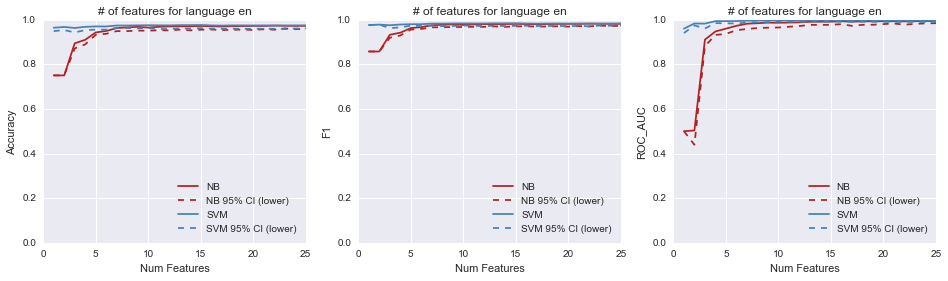

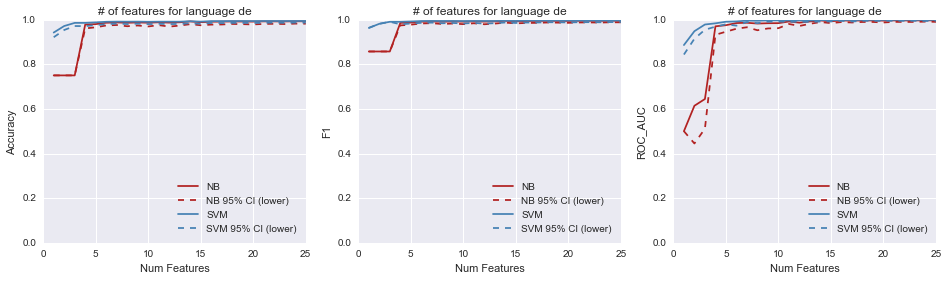

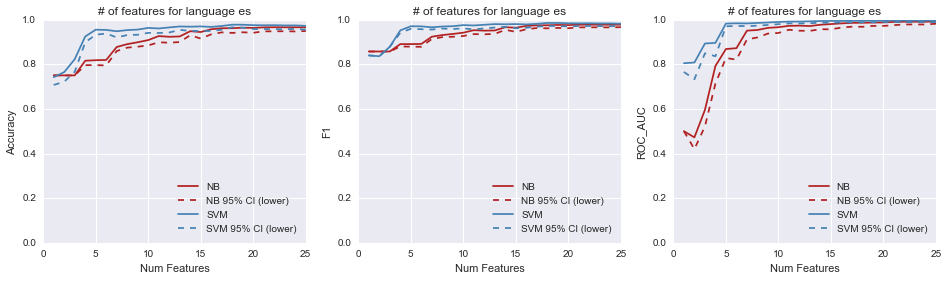

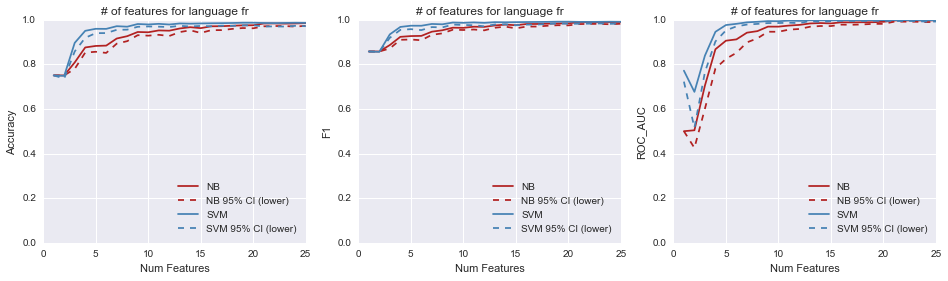

In [75]:
def experiment_4(corpi, language, num_features, feature_sampl):
    
    # Get the feature sampling corpus. Categories has to be restricted to the language of interest
    fs_corpus = skds.load_files(corpi[language], encoding='UTF-8', shuffle=True, categories=[language])
    
    # Discover features by count
    sub_sample = train_test_split(fs_corpus.data, fs_corpus.target, train_size=feature_sampling_perc)[0]
    vectorizer = TfidfVectorizer(analyzer='word', lowercase=True, encoding='UTF-8', use_idf=False,
                                   max_features=num_features, token_pattern=single_char_token_pattern())
    vectorizer.fit(sub_sample)
    
    # Load the language corpus & fit a Naive Bayes classifier
    corpus = skds.load_files(corpi[language], encoding='UTF-8', shuffle=True)
    X = vectorizer.transform(corpus.data)
    y = corpus.target
    
    # Fit and evaluate a Naive Bayes Classifier
    classifier = MultinomialNB(fit_prior=True)
    scoring = ['accuracy','f1','roc_auc']
    nb_results = cross_validate(classifier, X, y, cv=10, scoring=scoring)
    
    # Fit and evaluate an SVM
    classifier = svm.SVC(kernel='rbf', C=1)
    svm_results = cross_validate(classifier, X, y, cv=10, scoring=scoring)
    
    # kernel=rbf (default)
    # decision function shape = ovo ( one-vs-rest) - original decision function in libsvm
    #  tol is the default 1e-3
    # default C = 1
    return {
        'num_features' : num_features,
        'features': vectorizer.get_feature_names(),
        'NB' : {
            'accuracy' : nb_results['test_accuracy'].mean(),
            'accuracy_95CI': nb_results['test_accuracy'].std() * 2,
            'f1' : nb_results['test_f1'].mean(),
            'f1_95CI': nb_results['test_f1'].std() * 2,
            'auc' : nb_results['test_roc_auc'].mean(),
            'auc_95CI': nb_results['test_roc_auc'].std() * 2
        },
        'SVM' : {
            'accuracy': svm_results['test_accuracy'].mean(),
            'accuracy_95CI' : svm_results['test_accuracy'].std() * 2,
            'f1': svm_results['test_f1'].mean(),
            'f1_95CI': svm_results['test_f1'].std() * 2,
            'auc': svm_results['test_roc_auc'].mean(),
            'auc_95CI': svm_results['test_roc_auc'].std() * 2
        }
    }



# Run experiment for each language
print "Experiment 4"
for language in lang_map:
    
    # Run tests for a language
    print "----------------------------------"
    print "----------------------------------"
    print "Starting experiments for language {0}".format(language)
    
    # Extract feature space
    corpus = skds.load_files(corpi[language], encoding='UTF-8', shuffle=True, categories=[language])
    feature_sample = train_test_split(corpus.data, corpus.target, train_size=.10)[0]
    
    feature_ranks = []
    results = []
    
    # run the experiment
    for num_features in range(1, 25+1):
        exp_res = experiment_4(corpi, language, num_features, feature_sample)
        print "----------------------------------"
        print "Results for (lang: {0}, features: {1})".format(language, exp_res['num_features'])
        print "Features selected: {0}".format(exp_res['features'])
        print "Naive Bayes:"
        print "\tAccuracy {0}, +\/-95%CI {1}".format(exp_res['NB']['accuracy'], exp_res['NB']['accuracy_95CI'])
        print "\tF1 {0}, +\/-95%CI {1}".format(exp_res['NB']['f1'], exp_res['NB']['f1_95CI'])
        print "\tauc {0}, +\-95%CI {1}".format(exp_res['NB']['auc'],exp_res['NB']['auc_95CI'] )
        print "SVM:"
        print "\tAccuracy {0}, +\/-95%CI {1}".format(exp_res['SVM']['accuracy'], exp_res['SVM']['accuracy_95CI'])
        print "\tF1 {0}, +\/-95%CI {1}".format(exp_res['SVM']['f1'], exp_res['SVM']['f1_95CI'])
        print "\tauc {0}, +\-95%CI {1}".format(exp_res['SVM']['auc'],exp_res['SVM']['auc_95CI'] )
        results.append(exp_res)
        
        if len(feature_ranks) == 0:
            feature_ranks.append(exp_res['features'][0])
        else:
            for feature in exp_res['features']:
                if feature not in feature_ranks:
                    feature_ranks.append(feature)

    # Plotting NB
    figure = plt.figure(figsize=(16,4))
    nf = [result['num_features'] for result in results]
    
    # Accuracy on NB, SVM
    axes = figure.add_subplot(1,2,1)
    axes.set_title("Accuracy for {0}".format(lang_map[language]))
    axes.title.set_fontsize(title_fontsize)
    # NB plot
    nb_acc = [result['NB']['accuracy'] for result in results]
    nb_acc_lower = [result['NB']['accuracy'] - result['NB']['accuracy_95CI'] for result in results]
    h1, = axes.plot(nf, nb_acc, color='firebrick', label='NB')
    h2, = axes.plot(nf, nb_acc_lower, color='firebrick', linestyle='dashed', label='NB 95% CI (lower)')
    # SVM plot
    svm_acc = [result['SVM']['accuracy'] for result in results]
    svm_acc_lower = [result['SVM']['accuracy'] - result['SVM']['accuracy_95CI'] for result in results]
    h3, = axes.plot(nf, svm_acc, color='steelblue', label='SVM')
    h4, = axes.plot(nf, svm_acc_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h1, h2,h3, h4], loc='lower right', prop= {'size': legend_fontsize})
    axes.set_ylim([0,1])
    axes.set_ylabel("Accuracy")
    axes.set_ylim([0,1])
    axes.yaxis.get_label().set_fontsize(y_axis_fontsize)
    for tick in axes.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_axis_fontsize)
    axes.set_xlabel("# of Features")
    axes.xaxis.get_label().set_fontsize(x_axis_fontsize)
    for tick in axes.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_axis_fontsize)


    # AUC on NB, SVM
    axes = figure.add_subplot(1,2,2)
    axes.set_title("AUC for {0}".format(lang_map[language]))
    axes.title.set_fontsize(title_fontsize)
    # NB plot
    nb_auc = [result['NB']['auc'] for result in results]
    nb_auc_lower = [result['NB']['auc'] - result['NB']['auc_95CI'] for result in results]
    h1, = axes.plot(nf, nb_auc, color='firebrick', label='NB')
    h2, = axes.plot(nf, nb_auc_lower, color='firebrick', linestyle='dashed', label='NB 95% CI (lower)')
    # SVM plot
    svm_auc = [result['SVM']['auc'] for result in results]
    svm_auc_lower = [result['SVM']['auc'] - result['SVM']['auc_95CI'] for result in results]
    h3, = axes.plot(nf, svm_auc, color='steelblue', label='SVM')
    h4, = axes.plot(nf, svm_auc_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h1, h2, h3, h4], loc='lower right', prop= {'size': legend_fontsize})
    axes.set_ylim([0,1])
    axes.set_ylabel("ROC_AUC")
    axes.yaxis.get_label().set_fontsize(y_axis_fontsize)
    for tick in axes.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_axis_fontsize)
    axes.set_xlabel("# of Features")
    axes.xaxis.get_label().set_fontsize(x_axis_fontsize)
    for tick in axes.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_axis_fontsize)
    axes.set_ylim([0,1])

    print "Features in rank order were {0}".format(feature_ranks)
    print "Finished experiments for language {0}".format(language)








**Experiment 5**:  Can uni-grams and bi-grams help us?

Results for experiment 5
----------------------------------
----------------------------------
Starting experiments for language en
----------------------------------
Results for (lang: en, features: 1)
Features selected: [u'the']
Naive Bayes:
	Accuracy 0.75, +\/-95%CI 0.0
	F1 0.857142857143, +\/-95%CI 0.0
	auc 0.5, +\-95%CI 0.0
SVM:
	Accuracy 0.9635, +\/-95%CI 0.0150332963784
	F1 0.975463990759, +\/-95%CI 0.0101277010381
	auc 0.959333333333, +\-95%CI 0.0195618676682
----------------------------------
Results for (lang: en, features: 2)
Features selected: [u'in', u'the']
Naive Bayes:
	Accuracy 0.77775, +\/-95%CI 0.019551214796
	F1 0.868379967416, +\/-95%CI 0.0102059756087
	auc 0.941863333333, +\-95%CI 0.0228091833358
SVM:
	Accuracy 0.9635, +\/-95%CI 0.0150332963784
	F1 0.975463990759, +\/-95%CI 0.0101277010381
	auc 0.957453333333, +\-95%CI 0.0207802994311
----------------------------------
Results for (lang: en, features: 3)
Features selected: [u'and', u'in', u'the']
Naive Bayes:
	Accu

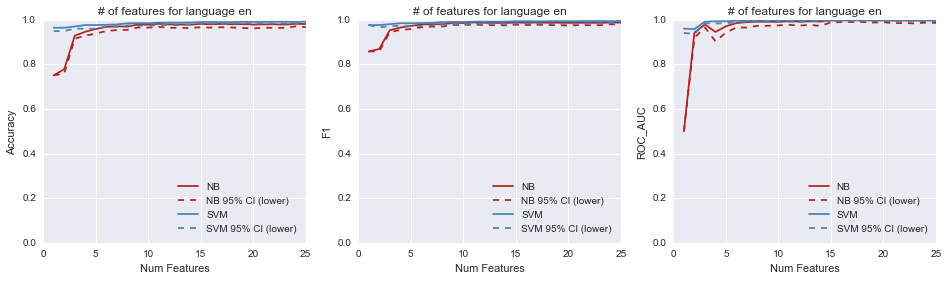

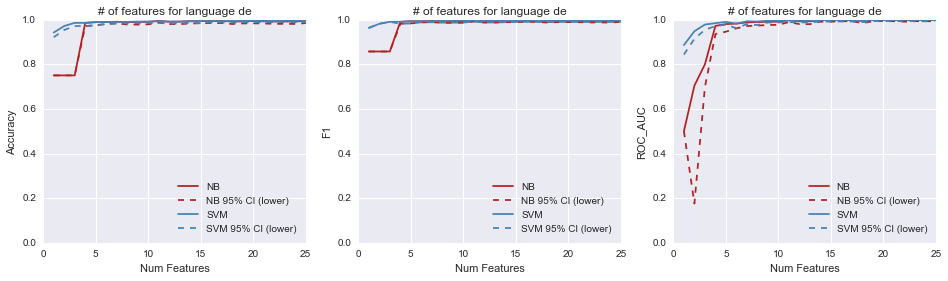

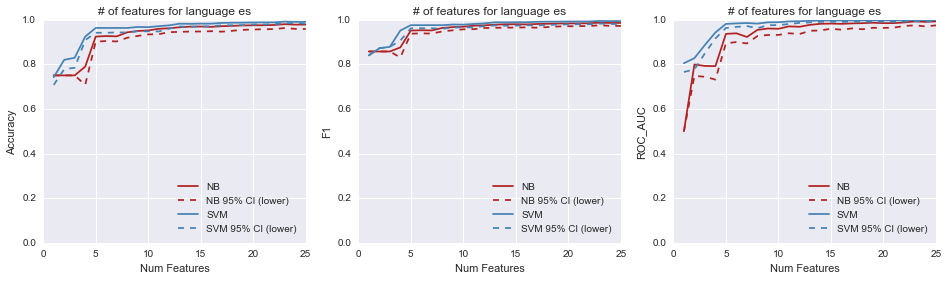

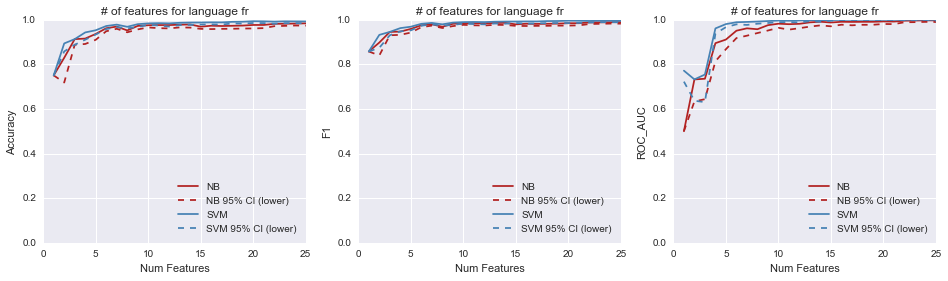

In [76]:
def experiment_5(corpi, language, num_features, feature_sampling_perc=.10):
    
    # Get the feature sampling corpus. Categories has to be restricted to the language of interest
    fs_corpus = skds.load_files(corpi[language], encoding='UTF-8', shuffle=True, categories=[language])
    
    # Discover features by count
    sub_sample = train_test_split(fs_corpus.data, fs_corpus.target, train_size=feature_sampling_perc)[0]
    vectorizer = CountVectorizer(analyzer='word', lowercase=True, encoding='UTF-8', ngram_range=(1,2),
                                   max_features=num_features, token_pattern=single_char_token_pattern(), binary=True)
    vectorizer.fit(sub_sample)
    
    # Load the language corpus & fit a Naive Bayes classifier
    corpus = skds.load_files(corpi[language], encoding='UTF-8', shuffle=True)
    X = vectorizer.transform(corpus.data)
    y = corpus.target
    
    # Fit and evaluate a Naive Bayes Classifier
    classifier = MultinomialNB(fit_prior=True)
    scoring = ['accuracy','f1','roc_auc']
    nb_results = cross_validate(classifier, X, y, cv=10, scoring=scoring)
    
    # Fit and evaluate an SVM
    classifier = svm.SVC(kernel='rbf', C=1)
    svm_results = cross_validate(classifier, X, y, cv=10, scoring=scoring)
    
    # kernel=rbf (default)
    # decision function shape = ovo ( one-vs-rest) - original decision function in libsvm
    #  tol is the default 1e-3
    # default C = 1
    return {
        'num_features' : num_features,
        'features': vectorizer.get_feature_names(),
        'NB' : {
            'accuracy' : nb_results['test_accuracy'].mean(),
            'accuracy_95CI': nb_results['test_accuracy'].std() * 2,
            'f1' : nb_results['test_f1'].mean(),
            'f1_95CI': nb_results['test_f1'].std() * 2,
            'auc' : nb_results['test_roc_auc'].mean(),
            'auc_95CI': nb_results['test_roc_auc'].std() * 2
        },
        'SVM' : {
            'accuracy': svm_results['test_accuracy'].mean(),
            'accuracy_95CI' : svm_results['test_accuracy'].std() * 2,
            'f1': svm_results['test_f1'].mean(),
            'f1_95CI': svm_results['test_f1'].std() * 2,
            'auc': svm_results['test_roc_auc'].mean(),
            'auc_95CI': svm_results['test_roc_auc'].std() * 2
        }
    }

print "Results for experiment 5"
for language in languages:
    
    # Run tests for a language
    print "----------------------------------"
    print "----------------------------------"
    print "Starting experiments for language {0}".format(language)
    results = []
    for num_features in range(1, 25+1):
        exp_res = experiment_5(corpi, language, num_features)
        print "----------------------------------"
        print "Results for (lang: {0}, features: {1})".format(language, exp_res['num_features'])
        print "Features selected: {0}".format(exp_res['features'])
        print "Naive Bayes:"
        print "\tAccuracy {0}, +\/-95%CI {1}".format(exp_res['NB']['accuracy'], exp_res['NB']['accuracy_95CI'])
        print "\tF1 {0}, +\/-95%CI {1}".format(exp_res['NB']['f1'], exp_res['NB']['f1_95CI'])
        print "\tauc {0}, +\-95%CI {1}".format(exp_res['NB']['auc'],exp_res['NB']['auc_95CI'] )
        print "SVM:"
        print "\tAccuracy {0}, +\/-95%CI {1}".format(exp_res['SVM']['accuracy'], exp_res['SVM']['accuracy_95CI'])
        print "\tF1 {0}, +\/-95%CI {1}".format(exp_res['SVM']['f1'], exp_res['SVM']['f1_95CI'])
        print "\tauc {0}, +\-95%CI {1}".format(exp_res['SVM']['auc'],exp_res['SVM']['auc_95CI'] )
        results.append(exp_res)
            
    # Plotting NB
    figure = plt.figure(figsize=(16,4))
    nf = [result['num_features'] for result in results]
    
    # Accuracy on NB, SVM
    axes = figure.add_subplot(1,3,1)
    axes.set_title("# of features for language {0}".format(language))
    # NB plot
    nb_acc = [result['NB']['accuracy'] for result in results]
    nb_acc_lower = [result['NB']['accuracy'] - result['NB']['accuracy_95CI'] for result in results]
    h1, = axes.plot(nf, nb_acc, color='firebrick', label='NB')
    h2, = axes.plot(nf, nb_acc_lower, color='firebrick', linestyle='dashed', label='NB 95% CI (lower)')
    # SVM plot
    svm_acc = [result['SVM']['accuracy'] for result in results]
    svm_acc_lower = [result['SVM']['accuracy'] - result['SVM']['accuracy_95CI'] for result in results]
    h3, = axes.plot(nf, svm_acc, color='steelblue', label='SVM')
    h4, = axes.plot(nf, svm_acc_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h1, h2,h3, h4], loc='lower right')
    axes.set_ylabel("Accuracy")
    axes.set_xlabel("Num Features")
    axes.set_ylim([0,1])

    # F1 on NB, SVM
    axes = figure.add_subplot(1,3,2)
    axes.set_title("# of features for language {0}".format(language))
    # NB plot
    nb_f1 = [result['NB']['f1'] for result in results]
    nb_f1_lower = [result['NB']['f1'] - result['NB']['f1_95CI'] for result in results]
    h1, = axes.plot(nf, nb_f1, color='firebrick', label='NB')
    h2, = axes.plot(nf, nb_f1_lower, color='firebrick', linestyle='dashed', label='NB 95% CI (lower)')
    # SVM plot
    svm_f1 =[result['SVM']['f1'] for result in results]
    svm_f1_lower = [result['SVM']['f1'] - result['NB']['f1_95CI'] for result in results]
    h3, = axes.plot(nf, svm_f1, color='steelblue', label='SVM')
    h4, = axes.plot(nf, svm_f1_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h1, h2, h3, h4], loc='lower right')
    axes.set_ylabel("F1")
    axes.set_xlabel("Num Features")
    axes.set_ylim([0,1])
    
    # AUC on NB, SVM
    axes = figure.add_subplot(1,3,3)
    axes.set_title("# of features for language {0}".format(language))
    # NB plot
    nb_auc = [result['NB']['auc'] for result in results]
    nb_auc_lower = [result['NB']['auc'] - result['NB']['auc_95CI'] for result in results]
    h1, = axes.plot(nf, nb_auc, color='firebrick', label='NB')
    h2, = axes.plot(nf, nb_auc_lower, color='firebrick', linestyle='dashed', label='NB 95% CI (lower)')
    # SVM plot
    svm_auc = [result['SVM']['auc'] for result in results]
    svm_auc_lower = [result['SVM']['auc'] - result['SVM']['auc_95CI'] for result in results]
    h3, = axes.plot(nf, svm_auc, color='steelblue', label='SVM')
    h4, = axes.plot(nf, svm_auc_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h1, h2, h3, h4], loc='lower right')
    axes.set_ylabel("ROC_AUC")
    axes.set_xlabel("Num Features")
    axes.set_ylim([0,1])

    
    print "Finished experiments for language {0}".format(language)

**Experiment 6** What about bigrams only ? 

Starting experiment 6
----------------------------------
----------------------------------
Starting experiments for language en
----------------------------------
Results for (lang: en, features: 1)
Features selected: [u'in the']
Naive Bayes:
	Accuracy 0.75, +\/-95%CI 0.0
	F1 0.857142857143, +\/-95%CI 0.0
	auc 0.5, +\-95%CI 0.0
SVM:
	Accuracy 0.84325, +\/-95%CI 0.0232432785983
	F1 0.905374461786, +\/-95%CI 0.0126926946558
	auc 0.687166666667, +\-95%CI 0.0466202149764
----------------------------------
Results for (lang: en, features: 2)
Features selected: [u'in the', u'of the']
Naive Bayes:
	Accuracy 0.78925, +\/-95%CI 0.0478565564996
	F1 0.876915261901, +\/-95%CI 0.0242596350784
	auc 0.574905, +\-95%CI 0.0615235691964
SVM:
	Accuracy 0.896, +\/-95%CI 0.0238956062907
	F1 0.934846590304, +\/-95%CI 0.0137203996406
	auc 0.799428333333, +\-95%CI 0.0565790559012
----------------------------------
Results for (lang: en, features: 3)
Features selected: [u'and the', u'in the', u'of the']
Naive

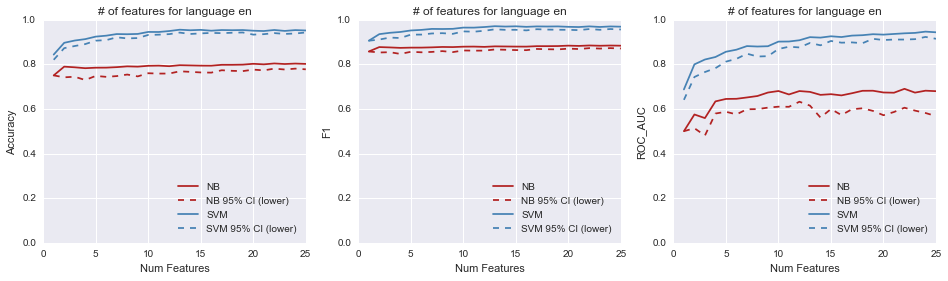

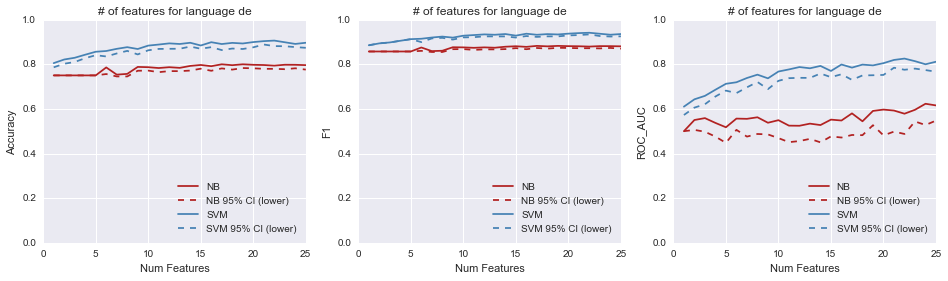

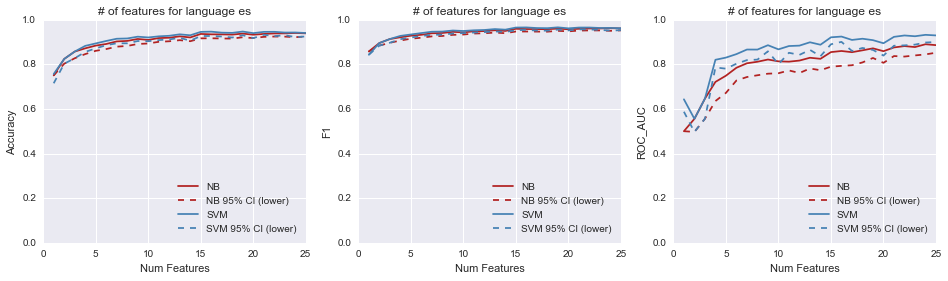

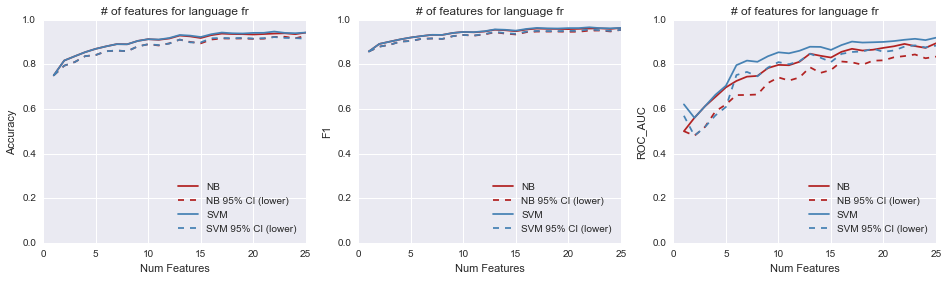

In [78]:
def experiment_6(corpi, language, num_features, feature_sampling_perc=.10):
    
    # Get the feature sampling corpus. Categories has to be restricted to the language of interest
    fs_corpus = skds.load_files(corpi[language], encoding='UTF-8', shuffle=True, categories=[language])
    
    # Discover features by count
    sub_sample = train_test_split(fs_corpus.data, fs_corpus.target, train_size=feature_sampling_perc)[0]
    vectorizer = CountVectorizer(analyzer='word', lowercase=True, encoding='UTF-8', ngram_range=(2,2),
                                   max_features=num_features, token_pattern=single_char_token_pattern(), binary=True)
    vectorizer.fit(sub_sample)
    
    # Load the language corpus & fit a Naive Bayes classifier
    corpus = skds.load_files(corpi[language], encoding='UTF-8', shuffle=True)
    X = vectorizer.transform(corpus.data)
    y = corpus.target
    
    # Fit and evaluate a Naive Bayes Classifier
    classifier = MultinomialNB(fit_prior=True)
    scoring = ['accuracy','f1','roc_auc']
    nb_results = cross_validate(classifier, X, y, cv=10, scoring=scoring)
    
    # Fit and evaluate an SVM
    classifier = svm.SVC(kernel='rbf', C=1)
    svm_results = cross_validate(classifier, X, y, cv=10, scoring=scoring)
    
    # kernel=rbf (default)
    # decision function shape = ovo ( one-vs-rest) - original decision function in libsvm
    #  tol is the default 1e-3
    # default C = 1
    return {
        'num_features' : num_features,
        'features': vectorizer.get_feature_names(),
        'NB' : {
            'accuracy' : nb_results['test_accuracy'].mean(),
            'accuracy_95CI': nb_results['test_accuracy'].std() * 2,
            'f1' : nb_results['test_f1'].mean(),
            'f1_95CI': nb_results['test_f1'].std() * 2,
            'auc' : nb_results['test_roc_auc'].mean(),
            'auc_95CI': nb_results['test_roc_auc'].std() * 2
        },
        'SVM' : {
            'accuracy': svm_results['test_accuracy'].mean(),
            'accuracy_95CI' : svm_results['test_accuracy'].std() * 2,
            'f1': svm_results['test_f1'].mean(),
            'f1_95CI': svm_results['test_f1'].std() * 2,
            'auc': svm_results['test_roc_auc'].mean(),
            'auc_95CI': svm_results['test_roc_auc'].std() * 2
        }
    }

print "Starting experiment 6"
for language in languages:
    
    # Run tests for a language
    print "----------------------------------"
    print "----------------------------------"
    print "Starting experiments for language {0}".format(language)
    results = []
    for num_features in range(1, 25+1):
        exp_res = experiment_6(corpi, language, num_features)
        print "----------------------------------"
        print "Results for (lang: {0}, features: {1})".format(language, exp_res['num_features'])
        print "Features selected: {0}".format(exp_res['features'])
        print "Naive Bayes:"
        print "\tAccuracy {0}, +\/-95%CI {1}".format(exp_res['NB']['accuracy'], exp_res['NB']['accuracy_95CI'])
        print "\tF1 {0}, +\/-95%CI {1}".format(exp_res['NB']['f1'], exp_res['NB']['f1_95CI'])
        print "\tauc {0}, +\-95%CI {1}".format(exp_res['NB']['auc'],exp_res['NB']['auc_95CI'] )
        print "SVM:"
        print "\tAccuracy {0}, +\/-95%CI {1}".format(exp_res['SVM']['accuracy'], exp_res['SVM']['accuracy_95CI'])
        print "\tF1 {0}, +\/-95%CI {1}".format(exp_res['SVM']['f1'], exp_res['SVM']['f1_95CI'])
        print "\tauc {0}, +\-95%CI {1}".format(exp_res['SVM']['auc'],exp_res['SVM']['auc_95CI'] )
        results.append(exp_res)
            
    # Plotting NB
    figure = plt.figure(figsize=(16,4))
    nf = [result['num_features'] for result in results]
    
    # Accuracy on NB, SVM
    axes = figure.add_subplot(1,3,1)
    axes.set_title("# of features for language {0}".format(language))
    # NB plot
    nb_acc = [result['NB']['accuracy'] for result in results]
    nb_acc_lower = [result['NB']['accuracy'] - result['NB']['accuracy_95CI'] for result in results]
    h1, = axes.plot(nf, nb_acc, color='firebrick', label='NB')
    h2, = axes.plot(nf, nb_acc_lower, color='firebrick', linestyle='dashed', label='NB 95% CI (lower)')
    # SVM plot
    svm_acc = [result['SVM']['accuracy'] for result in results]
    svm_acc_lower = [result['SVM']['accuracy'] - result['SVM']['accuracy_95CI'] for result in results]
    h3, = axes.plot(nf, svm_acc, color='steelblue', label='SVM')
    h4, = axes.plot(nf, svm_acc_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h1, h2,h3, h4], loc='lower right')
    axes.set_ylabel("Accuracy")
    axes.set_xlabel("Num Features")
    axes.set_ylim([0,1])

    # F1 on NB, SVM
    axes = figure.add_subplot(1,3,2)
    axes.set_title("# of features for language {0}".format(language))
    # NB plot
    nb_f1 = [result['NB']['f1'] for result in results]
    nb_f1_lower = [result['NB']['f1'] - result['NB']['f1_95CI'] for result in results]
    h1, = axes.plot(nf, nb_f1, color='firebrick', label='NB')
    h2, = axes.plot(nf, nb_f1_lower, color='firebrick', linestyle='dashed', label='NB 95% CI (lower)')
    # SVM plot
    svm_f1 =[result['SVM']['f1'] for result in results]
    svm_f1_lower = [result['SVM']['f1'] - result['NB']['f1_95CI'] for result in results]
    h3, = axes.plot(nf, svm_f1, color='steelblue', label='SVM')
    h4, = axes.plot(nf, svm_f1_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h1, h2, h3, h4], loc='lower right')
    axes.set_ylabel("F1")
    axes.set_xlabel("Num Features")
    axes.set_ylim([0,1])
    
    # AUC on NB, SVM
    axes = figure.add_subplot(1,3,3)
    axes.set_title("# of features for language {0}".format(language))
    # NB plot
    nb_auc = [result['NB']['auc'] for result in results]
    nb_auc_lower = [result['NB']['auc'] - result['NB']['auc_95CI'] for result in results]
    h1, = axes.plot(nf, nb_auc, color='firebrick', label='NB')
    h2, = axes.plot(nf, nb_auc_lower, color='firebrick', linestyle='dashed', label='NB 95% CI (lower)')
    # SVM plot
    svm_auc = [result['SVM']['auc'] for result in results]
    svm_auc_lower = [result['SVM']['auc'] - result['SVM']['auc_95CI'] for result in results]
    h3, = axes.plot(nf, svm_auc, color='steelblue', label='SVM')
    h4, = axes.plot(nf, svm_auc_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h1, h2, h3, h4], loc='lower right')
    axes.set_ylabel("ROC_AUC")
    axes.set_xlabel("Num Features")
    axes.set_ylim([0,1])

    
    print "Finished experiments for language {0}".format(language)

-----

**Lexical similarity**

In [84]:
lex_corpi = {
    'original' : '../data/lexical/corpus',
    'fr' : '../data/lexical/fr_corpus',
    'es' : '../data/lexical/es_corpus',
    'it' : '../data/lexical/it_corpus',
    'pt' : '../data/lexical/pt_corpus'
}
lex_languages = ['fr','es','it','pt']

**Experiment 7** How do we do when classifying languages with high lexical similarity?  Spanish, Italian, Portuguese and French. 

----------------------------------
----------------------------------
Starting experiments for language fr
----------------------------------
Results for (lang: fr, features: 1)
Features selected: [u'de']
Naive Bayes:
	Accuracy 0.75, +\/-95%CI 0.0
	F1 0.857142857143, +\/-95%CI 0.0
	auc 0.5, +\-95%CI 0.0
SVM:
	Accuracy 0.749, +\/-95%CI 0.00331662479036
	F1 0.856488393161, +\/-95%CI 0.00217131836749
	auc 0.51809, +\-95%CI 0.173089557551
----------------------------------
Results for (lang: fr, features: 2)
Features selected: [u'de', u'la']
Naive Bayes:
	Accuracy 0.75025, +\/-95%CI 0.0015
	F1 0.8572654813, +\/-95%CI 0.000735744941754
	auc 0.536001666667, +\-95%CI 0.0646339873613
SVM:
	Accuracy 0.7665, +\/-95%CI 0.016
	F1 0.853933465905, +\/-95%CI 0.00902333982081
	auc 0.661558333333, +\-95%CI 0.0717228063063
----------------------------------
Results for (lang: fr, features: 3)
Features selected: [u'a', u'de', u'la']
Naive Bayes:
	Accuracy 0.74225, +\/-95%CI 0.0315
	F1 0.839950321295, +\/

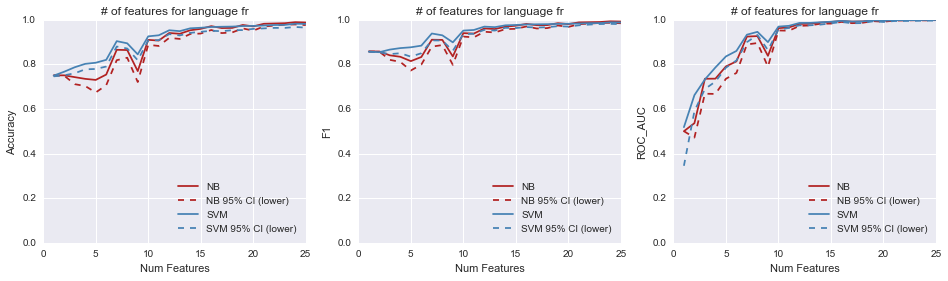

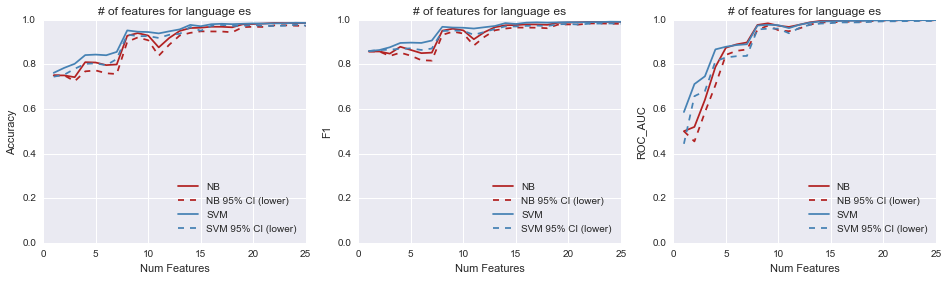

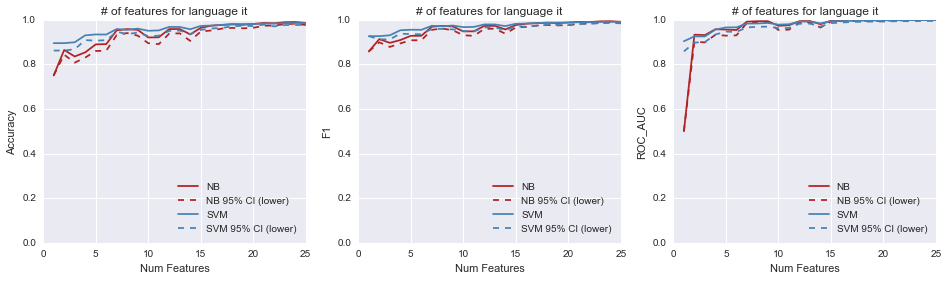

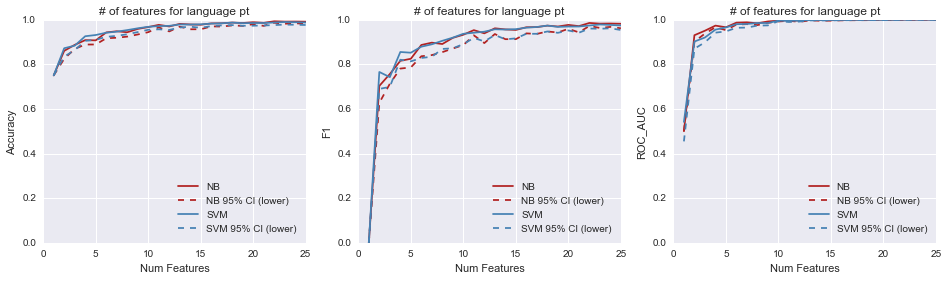

In [85]:
random.seed(123454321)
np.random.seed(123454321)

def experiment_7(corpi, language, num_features, feature_sampling_perc=.10):
    
    # Get the feature sampling corpus.  We'll sample from all languages here.
    fs_corpus = skds.load_files(corpi['original'], encoding='UTF-8', shuffle=True)
    
    # Discover features by count
    sub_sample = train_test_split(fs_corpus.data, fs_corpus.target, train_size=feature_sampling_perc)[0]
    vectorizer = CountVectorizer(analyzer='word', lowercase=True, encoding='UTF-8',
                                   max_features=num_features, token_pattern=single_char_token_pattern())
    vectorizer.fit(sub_sample)
    
    # Load the language corpus & fit a Naive Bayes classifier
    corpus = skds.load_files(corpi[language], encoding='UTF-8', shuffle=True)
    X = vectorizer.transform(corpus.data)
    y = corpus.target
    
    # Fit and evaluate a Naive Bayes Classifier
    classifier = MultinomialNB(fit_prior=True)
    scoring = ['accuracy','f1','roc_auc']
    nb_results = cross_validate(classifier, X, y, cv=10, scoring=scoring)
    
    # Fit and evaluate an SVM
    classifier = svm.SVC(kernel='rbf', C=1)
    svm_results = cross_validate(classifier, X, y, cv=10, scoring=scoring)
    
    # kernel=rbf (default)
    # decision function shape = ovo ( one-vs-rest) - original decision function in libsvm
    #  tol is the default 1e-3
    # default C = 1
    return {
        'num_features' : num_features,
        'features': vectorizer.get_feature_names(),
        'NB' : {
            'accuracy' : nb_results['test_accuracy'].mean(),
            'accuracy_95CI': nb_results['test_accuracy'].std() * 2,
            'f1' : nb_results['test_f1'].mean(),
            'f1_95CI': nb_results['test_f1'].std() * 2,
            'auc' : nb_results['test_roc_auc'].mean(),
            'auc_95CI': nb_results['test_roc_auc'].std() * 2
        },
        'SVM' : {
            'accuracy': svm_results['test_accuracy'].mean(),
            'accuracy_95CI' : svm_results['test_accuracy'].std() * 2,
            'f1': svm_results['test_f1'].mean(),
            'f1_95CI': svm_results['test_f1'].std() * 2,
            'auc': svm_results['test_roc_auc'].mean(),
            'auc_95CI': svm_results['test_roc_auc'].std() * 2
        }
    }



for language in lex_languages:
    
    # Run tests for a language
    print "----------------------------------"
    print "----------------------------------"
    print "Starting experiments for language {0}".format(language)
    results = []
    for num_features in range(1, 25+1):
        exp_res = experiment_7(lex_corpi, language, num_features)

        print "----------------------------------"
        print "Results for (lang: {0}, features: {1})".format(language, exp_res['num_features'])
        print "Features selected: {0}".format(exp_res['features'])
        print "Naive Bayes:"
        print "\tAccuracy {0}, +\/-95%CI {1}".format(exp_res['NB']['accuracy'], exp_res['NB']['accuracy_95CI'])
        print "\tF1 {0}, +\/-95%CI {1}".format(exp_res['NB']['f1'], exp_res['NB']['f1_95CI'])
        print "\tauc {0}, +\-95%CI {1}".format(exp_res['NB']['auc'],exp_res['NB']['auc_95CI'] )
        print "SVM:"
        print "\tAccuracy {0}, +\/-95%CI {1}".format(exp_res['SVM']['accuracy'], exp_res['SVM']['accuracy_95CI'])
        print "\tF1 {0}, +\/-95%CI {1}".format(exp_res['SVM']['f1'], exp_res['SVM']['f1_95CI'])
        print "\tauc {0}, +\-95%CI {1}".format(exp_res['SVM']['auc'],exp_res['SVM']['auc_95CI'] )
        results.append(exp_res)
            
    # Plotting NB
    figure = plt.figure(figsize=(16,4))
    nf = [result['num_features'] for result in results]
    
    # Accuracy on NB, SVM
    axes = figure.add_subplot(1,3,1)
    axes.set_title("# of features for language {0}".format(language))
    # NB plot
    nb_acc = [result['NB']['accuracy'] for result in results]
    nb_acc_lower = [result['NB']['accuracy'] - result['NB']['accuracy_95CI'] for result in results]
    h1, = axes.plot(nf, nb_acc, color='firebrick', label='NB')
    h2, = axes.plot(nf, nb_acc_lower, color='firebrick', linestyle='dashed', label='NB 95% CI (lower)')
    # SVM plot
    svm_acc = [result['SVM']['accuracy'] for result in results]
    svm_acc_lower = [result['SVM']['accuracy'] - result['SVM']['accuracy_95CI'] for result in results]
    h3, = axes.plot(nf, svm_acc, color='steelblue', label='SVM')
    h4, = axes.plot(nf, svm_acc_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h1, h2,h3, h4], loc='lower right')
    axes.set_ylabel("Accuracy")
    axes.set_xlabel("Num Features")
    axes.set_ylim([0,1])

    # F1 on NB, SVM
    axes = figure.add_subplot(1,3,2)
    axes.set_title("# of features for language {0}".format(language))
    # NB plot
    nb_f1 = [result['NB']['f1'] for result in results]
    nb_f1_lower = [result['NB']['f1'] - result['NB']['f1_95CI'] for result in results]
    h1, = axes.plot(nf, nb_f1, color='firebrick', label='NB')
    h2, = axes.plot(nf, nb_f1_lower, color='firebrick', linestyle='dashed', label='NB 95% CI (lower)')
    # SVM plot
    svm_f1 =[result['SVM']['f1'] for result in results]
    svm_f1_lower = [result['SVM']['f1'] - result['NB']['f1_95CI'] for result in results]
    h3, = axes.plot(nf, svm_f1, color='steelblue', label='SVM')
    h4, = axes.plot(nf, svm_f1_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h1, h2, h3, h4], loc='lower right')
    axes.set_ylabel("F1")
    axes.set_xlabel("Num Features")
    axes.set_ylim([0,1])
    
    # AUC on NB, SVM
    axes = figure.add_subplot(1,3,3)
    axes.set_title("# of features for language {0}".format(language))
    # NB plot
    nb_auc = [result['NB']['auc'] for result in results]
    nb_auc_lower = [result['NB']['auc'] - result['NB']['auc_95CI'] for result in results]
    h1, = axes.plot(nf, nb_auc, color='firebrick', label='NB')
    h2, = axes.plot(nf, nb_auc_lower, color='firebrick', linestyle='dashed', label='NB 95% CI (lower)')
    # SVM plot
    svm_auc = [result['SVM']['auc'] for result in results]
    svm_auc_lower = [result['SVM']['auc'] - result['SVM']['auc_95CI'] for result in results]
    h3, = axes.plot(nf, svm_auc, color='steelblue', label='SVM')
    h4, = axes.plot(nf, svm_auc_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h1, h2, h3, h4], loc='lower right')
    axes.set_ylabel("ROC_AUC")
    axes.set_xlabel("Num Features")
    axes.set_ylim([0,1])

    
    print "Finished experiments for language {0}".format(language)

**Experiment 7**:  Language specific words, uni-grams & bi-grams, binary=True

----------------------------------
----------------------------------
Starting experiments for language fr
----------------------------------
Results for (lang: fr, features: 1)
Features selected: [u'de']
Naive Bayes:
	Accuracy 0.75, +\/-95%CI 0.0
	F1 0.857142857143, +\/-95%CI 0.0
	auc 0.5, +\-95%CI 0.0
SVM:
	Accuracy 0.75, +\/-95%CI 0.0
	F1 0.857142857143, +\/-95%CI 0.0
	auc 0.629, +\-95%CI 0.0411015003781
----------------------------------
Results for (lang: fr, features: 2)
Features selected: [u'de', u'la']
Naive Bayes:
	Accuracy 0.75, +\/-95%CI 0.0
	F1 0.857142857143, +\/-95%CI 0.0
	auc 0.554108333333, +\-95%CI 0.0776985517526
SVM:
	Accuracy 0.75, +\/-95%CI 0.0
	F1 0.857142857143, +\/-95%CI 0.0
	auc 0.689755, +\-95%CI 0.0488057078857
----------------------------------
Results for (lang: fr, features: 3)
Features selected: [u'a', u'de', u'la']
Naive Bayes:
	Accuracy 0.75, +\/-95%CI 0.0
	F1 0.857142857143, +\/-95%CI 0.0
	auc 0.754265, +\-95%CI 0.0609713000791
SVM:
	Accuracy 0.79175, 

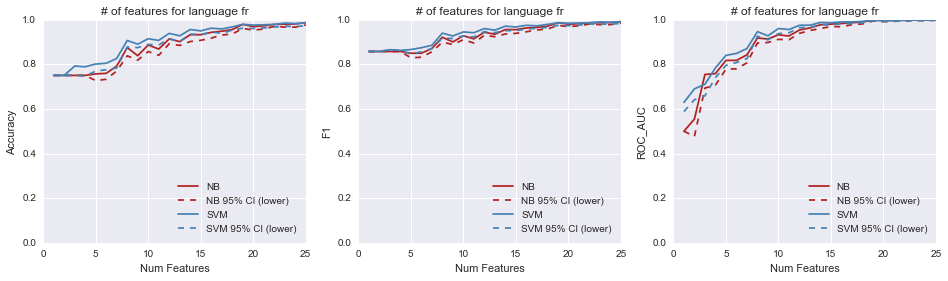

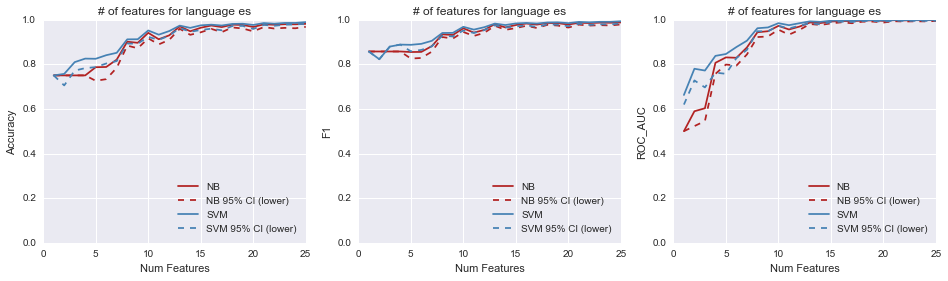

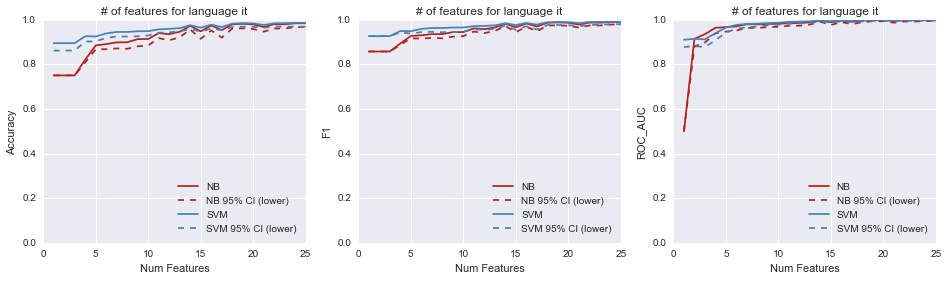

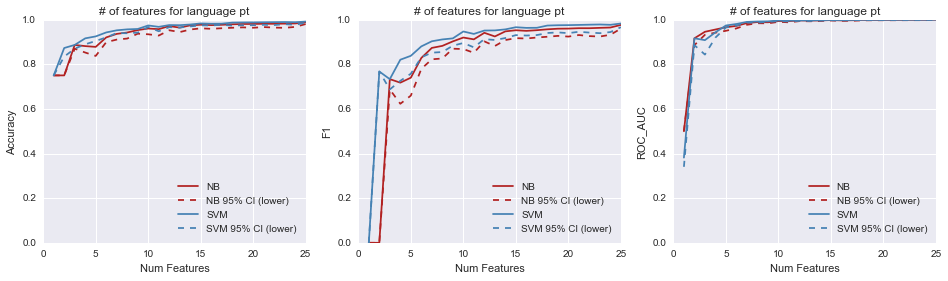

In [89]:
def experiment_7(corpi, language, num_features, feature_sampling_perc=.10):
    
    # sample from the lanuage corpu
    fs_corpus = skds.load_files(corpi[language], encoding='UTF-8', shuffle=True)
    
    # Discover features by count
    sub_sample = train_test_split(fs_corpus.data, fs_corpus.target, train_size=feature_sampling_perc)[0]
    vectorizer = CountVectorizer(analyzer='word', lowercase=True, encoding='UTF-8', ngram_range=(1,2),
                                   max_features=num_features, token_pattern=single_char_token_pattern(), binary=True)
    vectorizer.fit(sub_sample)
    
    # Load the language corpus & fit a Naive Bayes classifier
    corpus = skds.load_files(corpi[language], encoding='UTF-8', shuffle=True)
    X = vectorizer.transform(corpus.data)
    y = corpus.target
    
    # Fit and evaluate a Naive Bayes Classifier
    classifier = MultinomialNB(fit_prior=True)
    scoring = ['accuracy','f1','roc_auc']
    nb_results = cross_validate(classifier, X, y, cv=10, scoring=scoring)
    
    # Fit and evaluate an SVM
    classifier = svm.SVC(kernel='rbf', C=1)
    svm_results = cross_validate(classifier, X, y, cv=10, scoring=scoring)
    
    # kernel=rbf (default)
    # decision function shape = ovo ( one-vs-rest) - original decision function in libsvm
    #  tol is the default 1e-3
    # default C = 1
    return {
        'num_features' : num_features,
        'features': vectorizer.get_feature_names(),
        'NB' : {
            'accuracy' : nb_results['test_accuracy'].mean(),
            'accuracy_95CI': nb_results['test_accuracy'].std() * 2,
            'f1' : nb_results['test_f1'].mean(),
            'f1_95CI': nb_results['test_f1'].std() * 2,
            'auc' : nb_results['test_roc_auc'].mean(),
            'auc_95CI': nb_results['test_roc_auc'].std() * 2
        },
        'SVM' : {
            'accuracy': svm_results['test_accuracy'].mean(),
            'accuracy_95CI' : svm_results['test_accuracy'].std() * 2,
            'f1': svm_results['test_f1'].mean(),
            'f1_95CI': svm_results['test_f1'].std() * 2,
            'auc': svm_results['test_roc_auc'].mean(),
            'auc_95CI': svm_results['test_roc_auc'].std() * 2
        }
    }



for language in lex_languages:
    
    # Run tests for a language
    print "----------------------------------"
    print "----------------------------------"
    print "Starting experiments for language {0}".format(language)
    results = []
    for num_features in range(1, 25+1):
        exp_res = experiment_7(lex_corpi, language, num_features)

        print "----------------------------------"
        print "Results for (lang: {0}, features: {1})".format(language, exp_res['num_features'])
        print "Features selected: {0}".format(exp_res['features'])
        print "Naive Bayes:"
        print "\tAccuracy {0}, +\/-95%CI {1}".format(exp_res['NB']['accuracy'], exp_res['NB']['accuracy_95CI'])
        print "\tF1 {0}, +\/-95%CI {1}".format(exp_res['NB']['f1'], exp_res['NB']['f1_95CI'])
        print "\tauc {0}, +\-95%CI {1}".format(exp_res['NB']['auc'],exp_res['NB']['auc_95CI'] )
        print "SVM:"
        print "\tAccuracy {0}, +\/-95%CI {1}".format(exp_res['SVM']['accuracy'], exp_res['SVM']['accuracy_95CI'])
        print "\tF1 {0}, +\/-95%CI {1}".format(exp_res['SVM']['f1'], exp_res['SVM']['f1_95CI'])
        print "\tauc {0}, +\-95%CI {1}".format(exp_res['SVM']['auc'],exp_res['SVM']['auc_95CI'] )
        results.append(exp_res)
            
    # Plotting NB
    figure = plt.figure(figsize=(16,4))
    nf = [result['num_features'] for result in results]
    
    # Accuracy on NB, SVM
    axes = figure.add_subplot(1,3,1)
    axes.set_title("# of features for language {0}".format(language))
    # NB plot
    nb_acc = [result['NB']['accuracy'] for result in results]
    nb_acc_lower = [result['NB']['accuracy'] - result['NB']['accuracy_95CI'] for result in results]
    h1, = axes.plot(nf, nb_acc, color='firebrick', label='NB')
    h2, = axes.plot(nf, nb_acc_lower, color='firebrick', linestyle='dashed', label='NB 95% CI (lower)')
    # SVM plot
    svm_acc = [result['SVM']['accuracy'] for result in results]
    svm_acc_lower = [result['SVM']['accuracy'] - result['SVM']['accuracy_95CI'] for result in results]
    h3, = axes.plot(nf, svm_acc, color='steelblue', label='SVM')
    h4, = axes.plot(nf, svm_acc_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h1, h2,h3, h4], loc='lower right')
    axes.set_ylabel("Accuracy")
    axes.set_xlabel("Num Features")
    axes.set_ylim([0,1])

    # F1 on NB, SVM
    axes = figure.add_subplot(1,3,2)
    axes.set_title("# of features for language {0}".format(language))
    # NB plot
    nb_f1 = [result['NB']['f1'] for result in results]
    nb_f1_lower = [result['NB']['f1'] - result['NB']['f1_95CI'] for result in results]
    h1, = axes.plot(nf, nb_f1, color='firebrick', label='NB')
    h2, = axes.plot(nf, nb_f1_lower, color='firebrick', linestyle='dashed', label='NB 95% CI (lower)')
    # SVM plot
    svm_f1 =[result['SVM']['f1'] for result in results]
    svm_f1_lower = [result['SVM']['f1'] - result['NB']['f1_95CI'] for result in results]
    h3, = axes.plot(nf, svm_f1, color='steelblue', label='SVM')
    h4, = axes.plot(nf, svm_f1_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h1, h2, h3, h4], loc='lower right')
    axes.set_ylabel("F1")
    axes.set_xlabel("Num Features")
    axes.set_ylim([0,1])
    
    # AUC on NB, SVM
    axes = figure.add_subplot(1,3,3)
    axes.set_title("# of features for language {0}".format(language))
    # NB plot
    nb_auc = [result['NB']['auc'] for result in results]
    nb_auc_lower = [result['NB']['auc'] - result['NB']['auc_95CI'] for result in results]
    h1, = axes.plot(nf, nb_auc, color='firebrick', label='NB')
    h2, = axes.plot(nf, nb_auc_lower, color='firebrick', linestyle='dashed', label='NB 95% CI (lower)')
    # SVM plot
    svm_auc = [result['SVM']['auc'] for result in results]
    svm_auc_lower = [result['SVM']['auc'] - result['SVM']['auc_95CI'] for result in results]
    h3, = axes.plot(nf, svm_auc, color='steelblue', label='SVM')
    h4, = axes.plot(nf, svm_auc_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h1, h2, h3, h4], loc='lower right')
    axes.set_ylabel("ROC_AUC")
    axes.set_xlabel("Num Features")
    axes.set_ylim([0,1])

    
    print "Finished experiments for language {0}".format(language)

**Experiment_8**
Separating bi-gram counts. 

Results for experiment 8
----------------------------------
----------------------------------
Starting experiments for language fr
----------------------------------
Results for (lang: fr, features: 1)
Features selected: [u'de']
Naive Bayes:
	Accuracy 0.75, +\/-95%CI 0.0
	F1 0.857142857143, +\/-95%CI 0.0
	auc 0.5, +\-95%CI 0.0
SVM:
	Accuracy 0.749, +\/-95%CI 0.00331662479036
	F1 0.856488393161, +\/-95%CI 0.00217131836749
	auc 0.51809, +\-95%CI 0.173089557551
----------------------------------
Results for (lang: fr, features: 2)
Features selected: [u'de', u'la']
Naive Bayes:
	Accuracy 0.75025, +\/-95%CI 0.0015
	F1 0.8572654813, +\/-95%CI 0.000735744941754
	auc 0.536001666667, +\-95%CI 0.0646339873613
SVM:
	Accuracy 0.7665, +\/-95%CI 0.016
	F1 0.853933465905, +\/-95%CI 0.00902333982081
	auc 0.661558333333, +\-95%CI 0.0717228063063
----------------------------------
Results for (lang: fr, features: 3)
Features selected: [u'a', u'de', u'la']
Naive Bayes:
	Accuracy 0.74225, +\/-95%CI 0.031

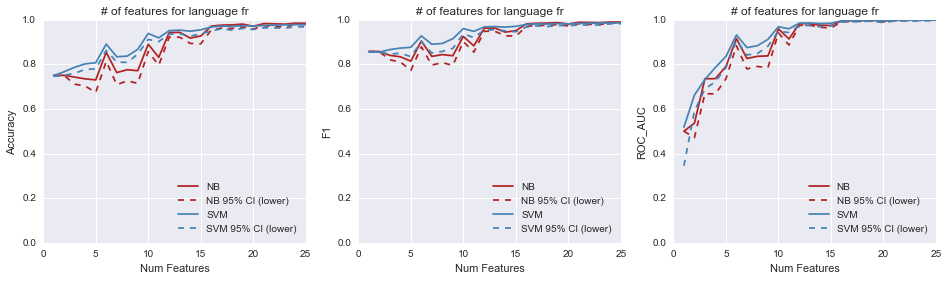

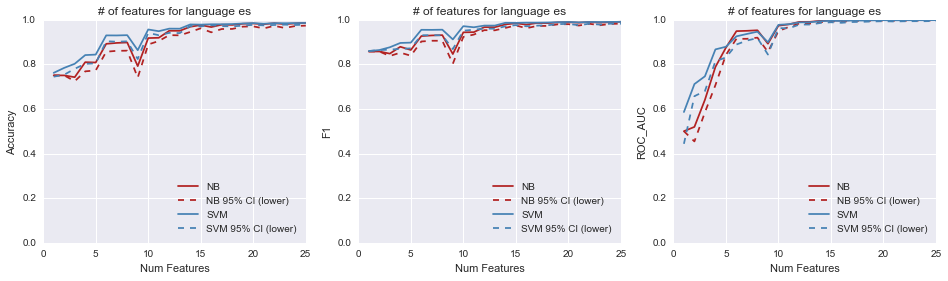

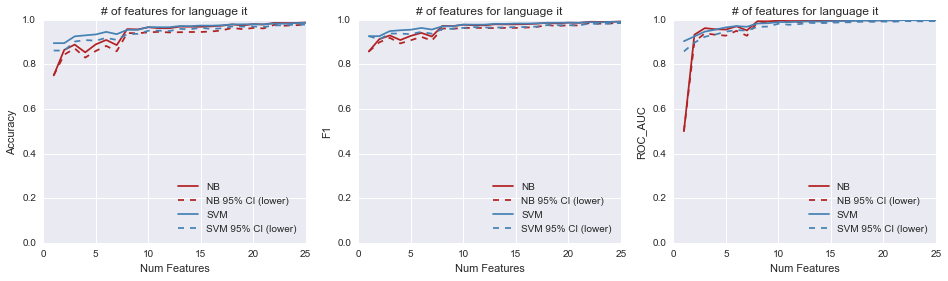

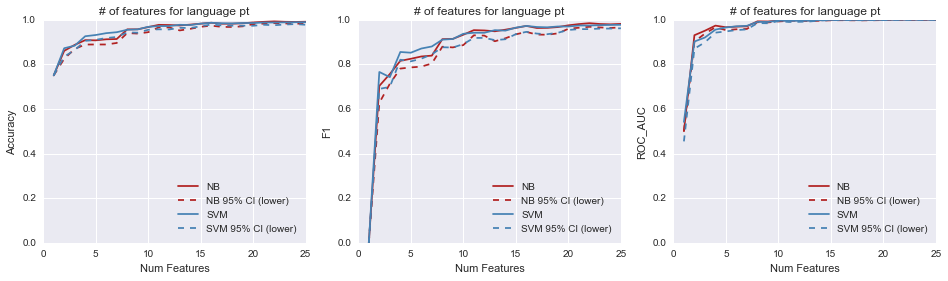

In [88]:
def experiment_8(corpi, language, num_features, feature_sampling_perc=.10):
    
    # sample from the lanuage corpu
    fs_corpus = skds.load_files(corpi[language], encoding='UTF-8', shuffle=True)
    
    # Discover features by count
    sub_sample = train_test_split(fs_corpus.data, fs_corpus.target, train_size=feature_sampling_perc)[0]
    vectorizer = CountVectorizer(analyzer='word', lowercase=True, encoding='UTF-8', ngram_range=(1,2),
                                   max_features=num_features, token_pattern=single_char_token_pattern())
    vectorizer.fit(sub_sample)
    
    # Load the language corpus & fit a Naive Bayes classifier
    corpus = skds.load_files(corpi[language], encoding='UTF-8', shuffle=True)
    X = vectorizer.transform(corpus.data)
    y = corpus.target
    
    # Fit and evaluate a Naive Bayes Classifier
    classifier = MultinomialNB(fit_prior=True)
    scoring = ['accuracy','f1','roc_auc']
    nb_results = cross_validate(classifier, X, y, cv=10, scoring=scoring)
    
    # Fit and evaluate an SVM
    classifier = svm.SVC(kernel='rbf', C=1)
    svm_results = cross_validate(classifier, X, y, cv=10, scoring=scoring)
    
    # kernel=rbf (default)
    # decision function shape = ovo ( one-vs-rest) - original decision function in libsvm
    #  tol is the default 1e-3
    # default C = 1
    return {
        'num_features' : num_features,
        'features': vectorizer.get_feature_names(),
        'NB' : {
            'accuracy' : nb_results['test_accuracy'].mean(),
            'accuracy_95CI': nb_results['test_accuracy'].std() * 2,
            'f1' : nb_results['test_f1'].mean(),
            'f1_95CI': nb_results['test_f1'].std() * 2,
            'auc' : nb_results['test_roc_auc'].mean(),
            'auc_95CI': nb_results['test_roc_auc'].std() * 2
        },
        'SVM' : {
            'accuracy': svm_results['test_accuracy'].mean(),
            'accuracy_95CI' : svm_results['test_accuracy'].std() * 2,
            'f1': svm_results['test_f1'].mean(),
            'f1_95CI': svm_results['test_f1'].std() * 2,
            'auc': svm_results['test_roc_auc'].mean(),
            'auc_95CI': svm_results['test_roc_auc'].std() * 2
        }
    }


print "Results for experiment 8"
for language in lex_languages:
    
    # Run tests for a language
    print "----------------------------------"
    print "----------------------------------"
    print "Starting experiments for language {0}".format(language)
    results = []
    for num_features in range(1, 25+1):
        exp_res = experiment_8(lex_corpi, language, num_features)

        print "----------------------------------"
        print "Results for (lang: {0}, features: {1})".format(language, exp_res['num_features'])
        print "Features selected: {0}".format(exp_res['features'])
        print "Naive Bayes:"
        print "\tAccuracy {0}, +\/-95%CI {1}".format(exp_res['NB']['accuracy'], exp_res['NB']['accuracy_95CI'])
        print "\tF1 {0}, +\/-95%CI {1}".format(exp_res['NB']['f1'], exp_res['NB']['f1_95CI'])
        print "\tauc {0}, +\-95%CI {1}".format(exp_res['NB']['auc'],exp_res['NB']['auc_95CI'] )
        print "SVM:"
        print "\tAccuracy {0}, +\/-95%CI {1}".format(exp_res['SVM']['accuracy'], exp_res['SVM']['accuracy_95CI'])
        print "\tF1 {0}, +\/-95%CI {1}".format(exp_res['SVM']['f1'], exp_res['SVM']['f1_95CI'])
        print "\tauc {0}, +\-95%CI {1}".format(exp_res['SVM']['auc'],exp_res['SVM']['auc_95CI'] )
        results.append(exp_res)
            
    # Plotting NB
    figure = plt.figure(figsize=(16,4))
    nf = [result['num_features'] for result in results]
    
    # Accuracy on NB, SVM
    axes = figure.add_subplot(1,3,1)
    axes.set_title("# of features for language {0}".format(language))
    # NB plot
    nb_acc = [result['NB']['accuracy'] for result in results]
    nb_acc_lower = [result['NB']['accuracy'] - result['NB']['accuracy_95CI'] for result in results]
    h1, = axes.plot(nf, nb_acc, color='firebrick', label='NB')
    h2, = axes.plot(nf, nb_acc_lower, color='firebrick', linestyle='dashed', label='NB 95% CI (lower)')
    # SVM plot
    svm_acc = [result['SVM']['accuracy'] for result in results]
    svm_acc_lower = [result['SVM']['accuracy'] - result['SVM']['accuracy_95CI'] for result in results]
    h3, = axes.plot(nf, svm_acc, color='steelblue', label='SVM')
    h4, = axes.plot(nf, svm_acc_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h1, h2,h3, h4], loc='lower right')
    axes.set_ylabel("Accuracy")
    axes.set_xlabel("Num Features")
    axes.set_ylim([0,1])

    # F1 on NB, SVM
    axes = figure.add_subplot(1,3,2)
    axes.set_title("# of features for language {0}".format(language))
    # NB plot
    nb_f1 = [result['NB']['f1'] for result in results]
    nb_f1_lower = [result['NB']['f1'] - result['NB']['f1_95CI'] for result in results]
    h1, = axes.plot(nf, nb_f1, color='firebrick', label='NB')
    h2, = axes.plot(nf, nb_f1_lower, color='firebrick', linestyle='dashed', label='NB 95% CI (lower)')
    # SVM plot
    svm_f1 =[result['SVM']['f1'] for result in results]
    svm_f1_lower = [result['SVM']['f1'] - result['NB']['f1_95CI'] for result in results]
    h3, = axes.plot(nf, svm_f1, color='steelblue', label='SVM')
    h4, = axes.plot(nf, svm_f1_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h1, h2, h3, h4], loc='lower right')
    axes.set_ylabel("F1")
    axes.set_xlabel("Num Features")
    axes.set_ylim([0,1])
    
    # AUC on NB, SVM
    axes = figure.add_subplot(1,3,3)
    axes.set_title("# of features for language {0}".format(language))
    # NB plot
    nb_auc = [result['NB']['auc'] for result in results]
    nb_auc_lower = [result['NB']['auc'] - result['NB']['auc_95CI'] for result in results]
    h1, = axes.plot(nf, nb_auc, color='firebrick', label='NB')
    h2, = axes.plot(nf, nb_auc_lower, color='firebrick', linestyle='dashed', label='NB 95% CI (lower)')
    # SVM plot
    svm_auc = [result['SVM']['auc'] for result in results]
    svm_auc_lower = [result['SVM']['auc'] - result['SVM']['auc_95CI'] for result in results]
    h3, = axes.plot(nf, svm_auc, color='steelblue', label='SVM')
    h4, = axes.plot(nf, svm_auc_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h1, h2, h3, h4], loc='lower right')
    axes.set_ylabel("ROC_AUC")
    axes.set_xlabel("Num Features")
    axes.set_ylim([0,1])

    
    print "Finished experiments for language {0}".format(language)

In [530]:
fr_features=set([u'che', u'da', u'dans', u'de', u'del', u'des', u'di', u'do', u'du', u'em', u'en', u'est', u'et', u'il', u'in', u'la', u'le', u'les', u'par', u'per', u'que', u'qui', u'se', u'un', u'une'])
it_features=set([u'che', u'da', u'dans', u'de', u'del', u'della', u'di', u'do', u'du', u'em', u'en', u'est', u'et', u'il', u'in', u'la', u'le', u'les', u'na', u'no', u'que', u'se', u'um', u'un', u'une'])
pt_features=set([u'com', u'da', u'dans', u'de', u'del', u'des', u'di', u'do', u'du', u'em', u'en', u'est', u'et', u'il', u'in', u'la', u'le', u'les', u'no', u'per', u'que', u'se', u'um', u'uma', u'un'])

intersection = set.intersection(fr_features, it_features, pt_features)
print "Intersection between all sets has {0} elements: {1}".format(len(intersection), intersection)
diff_fr_it = set.symmetric_difference(fr_features, it_features)
print "Symmetric diff between FR, IT has {0} elements: {1}".format(len(diff_fr_it), diff_fr_it)
diff_it_pt = set.symmetric_difference(it_features, pt_features)
print "Symmetric diff between IT, PT has {0} elements: {1}".format(len(diff_it_pt), diff_it_pt)
diff_pt_fr = set.symmetric_difference(pt_features, fr_features)
print "Symmetric diff between PT, FR has {0} elements: {1}".format(len(diff_pt_fr), diff_pt_fr)

features = {}
for feature_set in [fr_features, it_features, pt_features]:
    for f in feature_set:
        if f not in features:
            features[f] = 1
        else:
            features[f] += 1
        
unique_features = [f for f in features if features[f] == 1]
print "Here are the unique features: {0}".format(unique_features)

Intersection between all sets has 19 elements: set([u'em', u'do', u'en', u'du', u'la', u'et', u'di', u'dans', u'est', u'da', u'le', u'de', u'les', u'del', u'il', u'in', u'que', u'un', u'se'])
Symmetric diff between FR, IT has 8 elements: set([u'des', u'qui', u'par', u'na', u'no', u'per', u'um', u'della'])
Symmetric diff between IT, PT has 8 elements: set([u'che', u'com', u'per', u'uma', u'une', u'na', u'des', u'della'])
Symmetric diff between PT, FR has 8 elements: set([u'qui', u'par', u'che', u'no', u'um', u'une', u'uma', u'com'])
Here are the unique features: [u'par', u'na', u'uma', u'qui', u'della', u'com']


**Experiment 8:** Language specific bi-grams

In [520]:
it_features = [u'con la', u'dans la', u'dans le', u'dans les', u'de la', u'de um', u'de uma', u'dell alfabeto', u'di un', u'em de', u'est un', u'est une', u'et de', u'et la', u'et le', u'il est', u'il suo', u'la lettera', u'la lettre', u'la sua', u'la ville', u'of the', u'par la', u'per il', u'per la']
it_features = set(it_features)

pt_features = [u'con la', u'dans la', u'dans le', u'dans les', u'de la', u'de um', u'dell alfabeto', u'di un', u'em de', u'est un', u'est une', u'et de', u'et la', u'et le', u'il est', u'la lettera', u'la lettre', u'la sua', u'la ville', u'of the', u'par la', u'par le', u'per il', u'per la', u'utilis\xe9e dans']
pt_features = set(pt_features)

fr_features = [u'con la', u'dans la', u'dans le', u'dans les', u'de la', u'de son', u'de um', u'di un', u'em de', u'est un', u'est une', u'et de', u'et la', u'il est', u'il suo', u'la lettera', u'la lettre', u'la prima', u'la sua', u'la ville', u'of the', u'par la', u'per il', u'per la', u'qu il']
fr_features = set(fr_features)

print set.intersection(it_features, pt_features, fr_features)


print "Difference between IT and PT: {0}".format(set.difference(it_features, pt_features))
print "Difference between IT and FR: {0}".format(set.difference(it_features, fr_features))
print 'Difference between PR and FR: {0}'.format(set.difference(pt_features, fr_features))


set([u'dans les', u'em de', u'di un', u'of the', u'et de', u'par la', u'de um', u'dans la', u'con la', u'la lettre', u'la ville', u'dans le', u'est une', u'de la', u'il est', u'per la', u'est un', u'et la', u'la lettera', u'la sua', u'per il'])
Difference between IT and PT: set([u'il suo', u'de uma'])
Difference between IT and FR: set([u'de uma', u'et le', u'dell alfabeto'])
Difference between PR and FR: set([u'utilis\xe9e dans', u'par le', u'et le', u'dell alfabeto'])


**Experiment 9**:  Chi^2 test

----------------------------------
----------------------------------
Starting experiments for language pair: ['it', 'pt']
----------------------------------
Results for (pair: ['it', 'pt'], k: 1)
Features selected: [u'de']
Naive Bayes:
	Accuracy 0.5, +\/-95%CI 0.0
	F1 0.0, +\/-95%CI 0.0
	auc 0.5, +\-95%CI 0.0
SVM:
	Accuracy 0.896, +\/-95%CI 0.0462168800332
	F1 0.891117676619, +\/-95%CI 0.0494372300425
	auc 0.90605, +\-95%CI 0.0420510879764
----------------------------------
Results for (pair: ['it', 'pt'], k: 2)
Features selected: [u'de', u'di']
Naive Bayes:
	Accuracy 0.9175, +\/-95%CI 0.038275318418
	F1 0.911314635406, +\/-95%CI 0.0430078913647
	auc 0.978205, +\-95%CI 0.0111462504906
SVM:
	Accuracy 0.9175, +\/-95%CI 0.0364005494464
	F1 0.911099755572, +\/-95%CI 0.0413330316238
	auc 0.954585, +\-95%CI 0.0390488168835
----------------------------------
Results for (pair: ['it', 'pt'], k: 3)
Features selected: [u'de', u'di', u'la']
Naive Bayes:
	Accuracy 0.9195, +\/-95%CI 0.034481879299

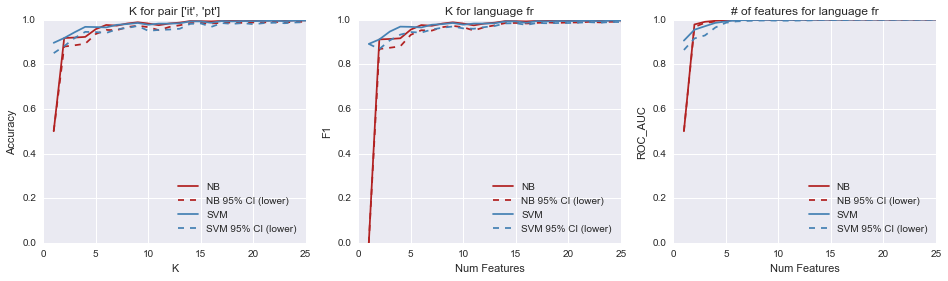

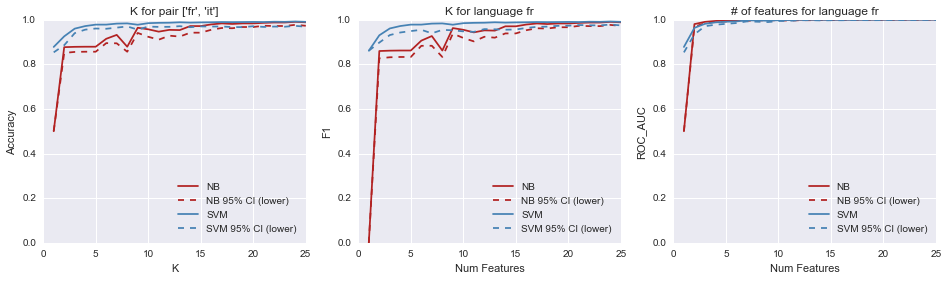

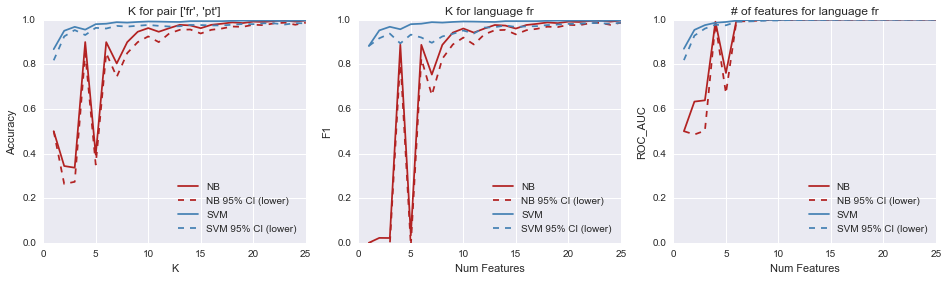

In [552]:
def experiment_9(corpi, languages, k, feature_sampling_perc=.10):
    
    # get whole corpus 
    corpus = skds.load_files(corpi['original'], encoding='UTF-8', shuffle=True, categories=languages)
    
    # Discover features by count
    X, X_t, y, y_t = train_test_split(corpus.data, corpus.target, train_size=feature_sampling_perc)
    vectorizer = CountVectorizer(analyzer='word', lowercase=True, encoding='UTF-8', token_pattern=())
    X = vectorizer.fit_transform(X)
    
    # Feature selection
    selector = SelectKBest(chi2, k=k)
    selector.fit(X, y)
    indices = selector.get_support(indices=True)
    
    # Transform
    X = selector.transform(vectorizer.transform(corpus.data))
    y = corpus.target
    
    # Fit and evaluate a Naive Bayes Classifier
    classifier = MultinomialNB(fit_prior=True)
    scoring = ['accuracy','f1','roc_auc']
    nb_results = cross_validate(classifier, X, y, cv=10, scoring=scoring)
    
    # Fit and evaluate an SVM
    classifier = svm.SVC(kernel='rbf', C=1)
    svm_results = cross_validate(classifier, X, y, cv=10, scoring=scoring)
    
    # kernel=rbf (default)
    # decision function shape = ovo ( one-vs-rest) - original decision function in libsvm
    #  tol is the default 1e-3
    # default C = 1
    return {
        'k' : k,
        'features': [vectorizer.get_feature_names()[i] for i in indices],
        'NB' : {
            'accuracy' : nb_results['test_accuracy'].mean(),
            'accuracy_95CI': nb_results['test_accuracy'].std() * 2,
            'f1' : nb_results['test_f1'].mean(),
            'f1_95CI': nb_results['test_f1'].std() * 2,
            'auc' : nb_results['test_roc_auc'].mean(),
            'auc_95CI': nb_results['test_roc_auc'].std() * 2
        },
        'SVM' : {
            'accuracy': svm_results['test_accuracy'].mean(),
            'accuracy_95CI' : svm_results['test_accuracy'].std() * 2,
            'f1': svm_results['test_f1'].mean(),
            'f1_95CI': svm_results['test_f1'].std() * 2,
            'auc': svm_results['test_roc_auc'].mean(),
            'auc_95CI': svm_results['test_roc_auc'].std() * 2
        }
    }



for pair in [['it','pt'],['fr','it'],['fr','pt']]:
    
    # Run tests for a language
    print "----------------------------------"
    print "----------------------------------"
    print "Starting experiments for language pair: {0}".format(pair)
    results = []
    for k in range(1, 25+1):
        exp_res = experiment_9(lex_corpi, pair, k)

        print "----------------------------------"
        print "Results for (pair: {0}, k: {1})".format(pair, exp_res['k'])
        print "Features selected: {0}".format(exp_res['features'])
        print "Naive Bayes:"
        print "\tAccuracy {0}, +\/-95%CI {1}".format(exp_res['NB']['accuracy'], exp_res['NB']['accuracy_95CI'])
        print "\tF1 {0}, +\/-95%CI {1}".format(exp_res['NB']['f1'], exp_res['NB']['f1_95CI'])
        print "\tauc {0}, +\-95%CI {1}".format(exp_res['NB']['auc'],exp_res['NB']['auc_95CI'] )
        print "SVM:"
        print "\tAccuracy {0}, +\/-95%CI {1}".format(exp_res['SVM']['accuracy'], exp_res['SVM']['accuracy_95CI'])
        print "\tF1 {0}, +\/-95%CI {1}".format(exp_res['SVM']['f1'], exp_res['SVM']['f1_95CI'])
        print "\tauc {0}, +\-95%CI {1}".format(exp_res['SVM']['auc'],exp_res['SVM']['auc_95CI'] )
        results.append(exp_res)
            
    # Plotting NB
    figure = plt.figure(figsize=(16,4))
    k = [result['k'] for result in results]
    
    # Accuracy on NB, SVM
    axes = figure.add_subplot(1,3,1)
    axes.set_title("K for pair {0}".format(pair))
    # NB plot
    nb_acc = [result['NB']['accuracy'] for result in results]
    nb_acc_lower = [result['NB']['accuracy'] - result['NB']['accuracy_95CI'] for result in results]
    h1, = axes.plot(k, nb_acc, color='firebrick', label='NB')
    h2, = axes.plot(k, nb_acc_lower, color='firebrick', linestyle='dashed', label='NB 95% CI (lower)')
    # SVM plot
    svm_acc = [result['SVM']['accuracy'] for result in results]
    svm_acc_lower = [result['SVM']['accuracy'] - result['SVM']['accuracy_95CI'] for result in results]
    h3, = axes.plot(k, svm_acc, color='steelblue', label='SVM')
    h4, = axes.plot(k, svm_acc_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h1, h2,h3, h4], loc='lower right')
    axes.set_ylabel("Accuracy")
    axes.set_xlabel("K")
    axes.set_ylim([0,1])

    # F1 on NB, SVM
    axes = figure.add_subplot(1,3,2)
    axes.set_title("K for language {0}".format(language))
    # NB plot
    nb_f1 = [result['NB']['f1'] for result in results]
    nb_f1_lower = [result['NB']['f1'] - result['NB']['f1_95CI'] for result in results]
    h1, = axes.plot(k, nb_f1, color='firebrick', label='NB')
    h2, = axes.plot(k, nb_f1_lower, color='firebrick', linestyle='dashed', label='NB 95% CI (lower)')
    # SVM plot
    svm_f1 =[result['SVM']['f1'] for result in results]
    svm_f1_lower = [result['SVM']['f1'] - result['NB']['f1_95CI'] for result in results]
    h3, = axes.plot(k, svm_f1, color='steelblue', label='SVM')
    h4, = axes.plot(k, svm_f1_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h1, h2, h3, h4], loc='lower right')
    axes.set_ylabel("F1")
    axes.set_xlabel("Num Features")
    axes.set_ylim([0,1])
    
    # AUC on NB, SVM
    axes = figure.add_subplot(1,3,3)
    axes.set_title("# of features for language {0}".format(language))
    # NB plot
    nb_auc = [result['NB']['auc'] for result in results]
    nb_auc_lower = [result['NB']['auc'] - result['NB']['auc_95CI'] for result in results]
    h1, = axes.plot(k, nb_auc, color='firebrick', label='NB')
    h2, = axes.plot(k, nb_auc_lower, color='firebrick', linestyle='dashed', label='NB 95% CI (lower)')
    # SVM plot
    svm_auc = [result['SVM']['auc'] for result in results]
    svm_auc_lower = [result['SVM']['auc'] - result['SVM']['auc_95CI'] for result in results]
    h3, = axes.plot(k, svm_auc, color='steelblue', label='SVM')
    h4, = axes.plot(k, svm_auc_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h1, h2, h3, h4], loc='lower right')
    axes.set_ylabel("ROC_AUC")
    axes.set_xlabel("Num Features")
    axes.set_ylim([0,1])

    
    print "Finished experiments for language {0}".format(language)

